## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#%config InlineBackend.figure_format='retina'

from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Create global variables

In [2]:
cameraMatrix = None
distortionCoeffs = None

threshold = None
perspective = None

# Camera calibration

In [3]:

def calibration(path_to_images):
    """
    Given a set of images (checerboards with 9x6 internal points), this
    will create the cameraMatrix and distoritionCoefficients that will
    be used to undistort the image.
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(path_to_images)

    # Step through the list and search for chessboard corners
    gray_shape = None
    for fname in images:
        # open and convert to grayscale
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gray_shape = gray.shape

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # calibrate the camera and return the cameraMatrix and distortionCoefficients
    ret, mtx, distortion, _, _ =  cv2.calibrateCamera(objpoints,
                                                      imgpoints,
                                                      gray_shape[::-1],
                                                      None, None)
    return mtx, distortion

#
# The cameraMatrix and distortionCoeffs are used when undistorting images
#
cameraMatrix, distortionCoeffs = calibration('./camera_cal/calibration*.jpg')

# Undistort  images


In [4]:
def undistortImage(image):
    """
    Given the cameraMatrix and the distortionCoefficients generated by the
    calibration() function, this will undistort the image.
    """
    assert cameraMatrix is not None, "calibration() not run"
    assert distortionCoeffs is not None, "calibration() not run"

    return cv2.undistort(image, cameraMatrix, distortionCoeffs, None, cameraMatrix)

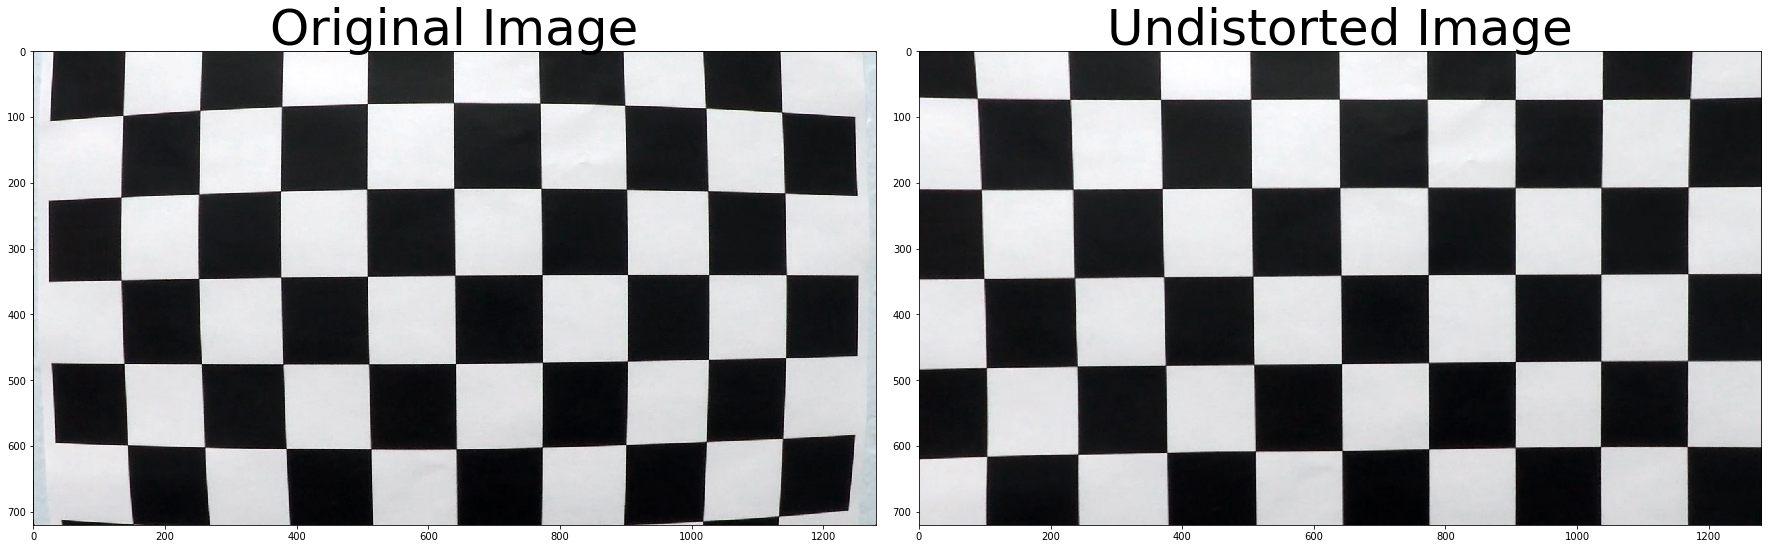

In [5]:
images = ['./camera_cal/calibration1.jpg']
img = cv2.imread(images[0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistortImage(img))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('calibration.png')

# Create a thresholded image 

In [6]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=(3,3), thresh=(0,255)):
    """
    Creates a filter, based on the Sobel operator, in either the x or y axis,
    depending on the orient parameter.    
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_mask = np.zeros_like(scaled_sobel)
    binary_mask[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_mask
    
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Creates a binary mask of an image based on the direction of the gradient.
    The size of the kernel is controlled by the sobel_kernel parameter.
    The lower and upper bounds for the thresholding is set by the thresh parameter.
    """
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_mask = np.zeros_like(abs_sobelx)
    binary_mask[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary_mask

def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    """
    Creates a binary mask of the image based on the magnitude of the gradient,
    in both the x and y directions.
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude
    dist = np.sqrt(sobelx*sobelx + sobely*sobely)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * dist / np.max(dist))

    # 5) Create a binary mask where mag thresholds are met
    binary_mask = np.zeros_like(scaled_sobel)
    binary_mask[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_mask



# Thresholding pipeline

## Exploratory work

In [7]:
# test1 - bridge
img_original = mpimg.imread('./test_images/test2.jpg')
# test4 - in shadow
img_original = mpimg.imread('./test_images/test5.jpg')
#img_original = mpimg.imread('./test_images/straight_lines2.jpg')

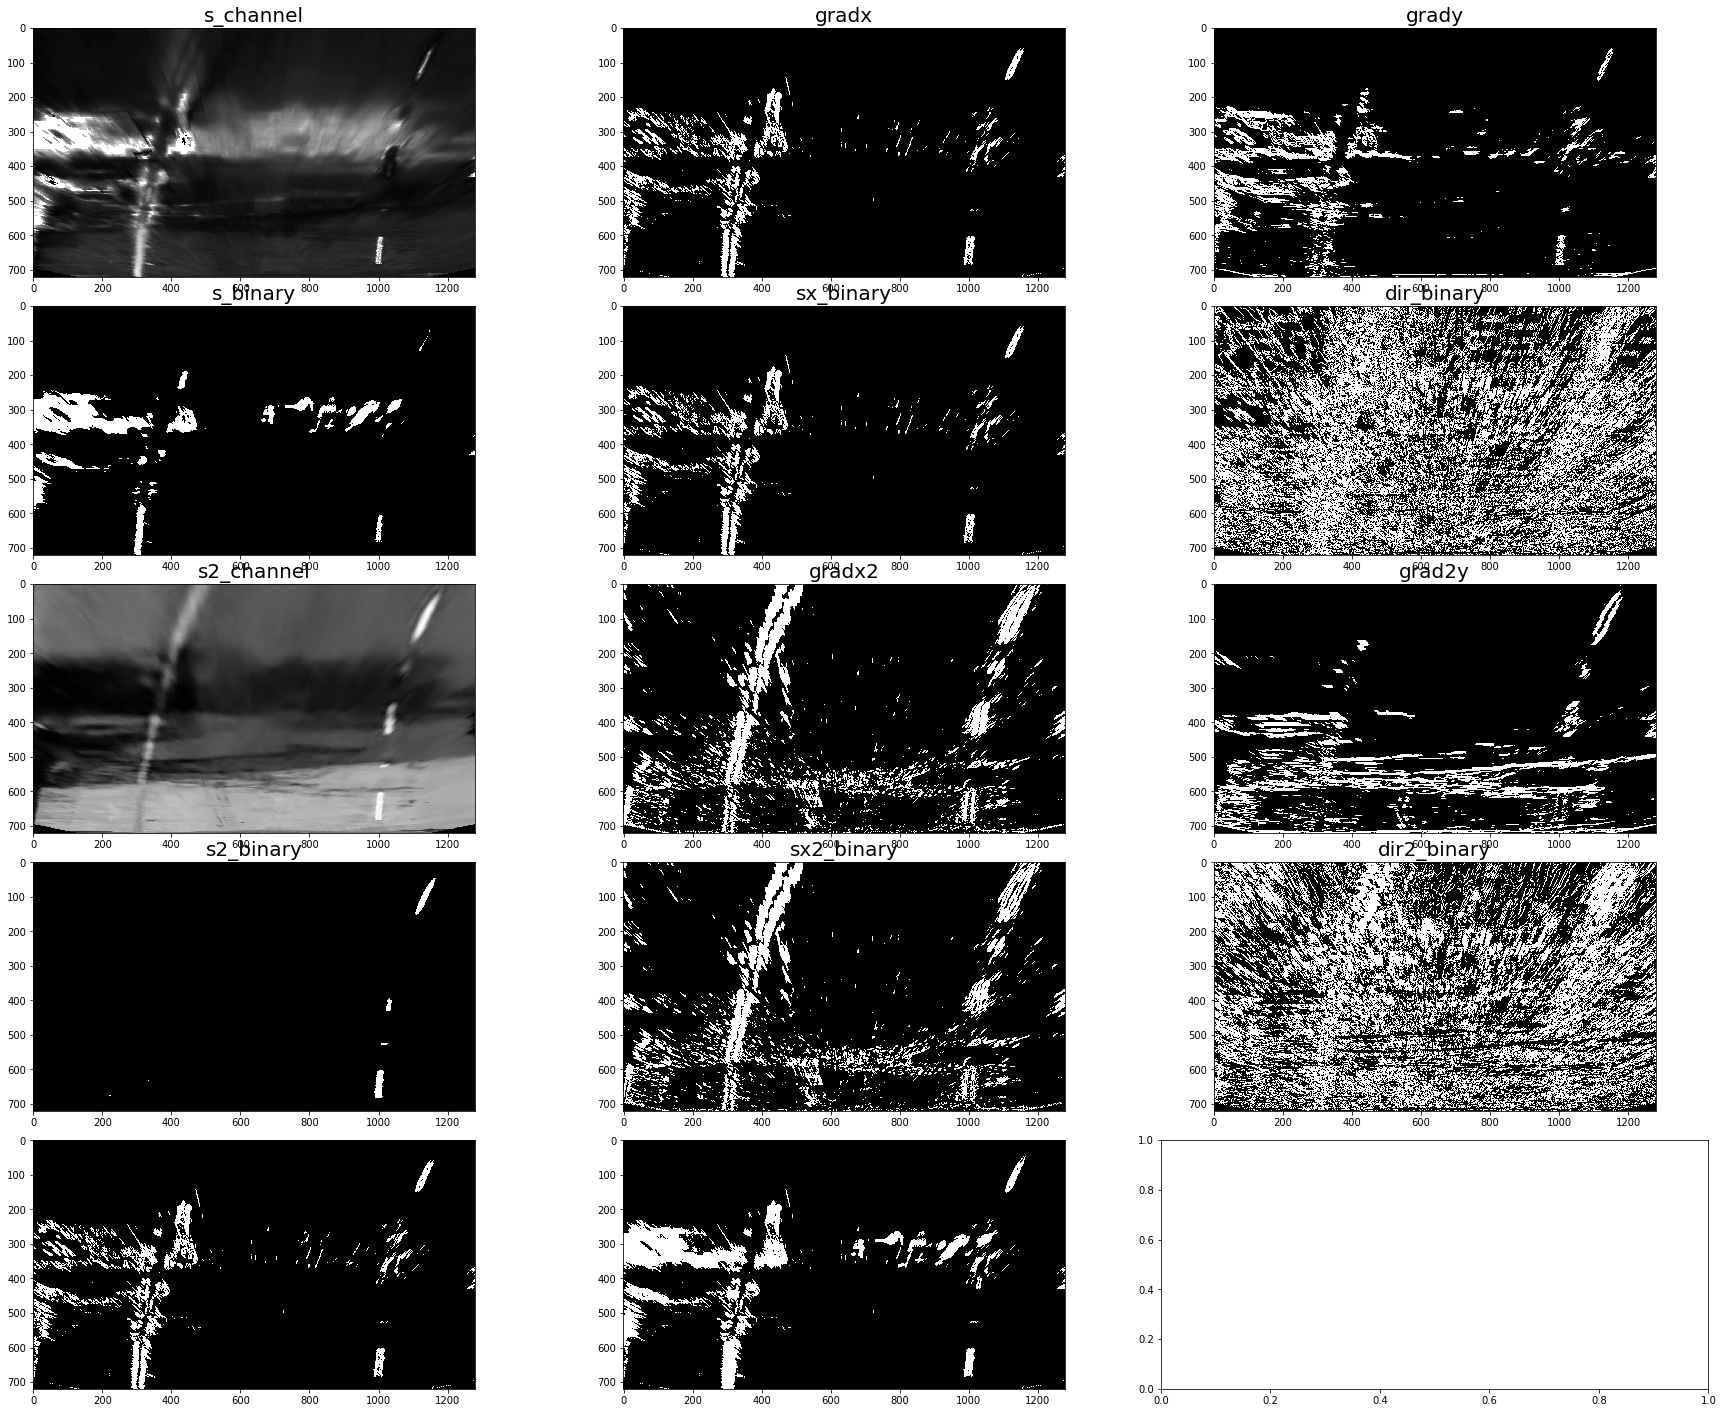

In [15]:
s_thresh = (10, 120)
color_thresh= (150, 255)
ksize=5
img = np.copy(img_original)
img = perspective.warp(img)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
h_channel = hls[:, :, 0]
l_channel = hls[:, :, 1]
s_channel = hls[:, :, 2]

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
h2_channel = hls[:, :, 0]
s2_channel = hls[:, :, 1]
v2_channel = hls[:, :, 2]

sx_binary = abs_sobel_thresh(s_channel, sobel_kernel=5, thresh=(10, 120))

dir_binary = dir_threshold(s_channel, sobel_kernel=3, thresh=(0.2, 1.3))
gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(10,250))
grady = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=(10,250))
mag_binary = mag_thresh(s_channel, sobel_kernel=ksize, thresh=(5, 180))

s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= 150) & (s_channel <= 255)] = 1


sx2_binary = abs_sobel_thresh(s2_channel, sobel_kernel=5, thresh=(10, 120))

dir2_binary = dir_threshold(s2_channel, sobel_kernel=3, thresh=(0.2, 1.3))
gradx2 = abs_sobel_thresh(s2_channel, orient='x', sobel_kernel=ksize, thresh=(10,250))
grady2 = abs_sobel_thresh(s2_channel, orient='y', sobel_kernel=ksize, thresh=(10,250))
mag2_binary = mag_thresh(s2_channel, sobel_kernel=ksize, thresh=(5, 180))

s2_binary = np.zeros_like(s2_channel)
s2_binary[(s2_channel >= 200) & (s2_channel <= 255)] = 1



f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (c1, c2, c3)) = plt.subplots(5, 3, figsize=(24, 21))
f.tight_layout()
#ax1.imshow(h_channel, cmap='gray')
#ax2.imshow(s_channel, cmap='gray')
#ax3.imshow(l_channel, cmap='gray')
#ax4.imshow(h2_channel, cmap='gray')
#ax5.imshow(s2_channel, cmap='gray')
#ax6.imshow(v2_channel, cmap='gray')
ax1.imshow(s_channel, cmap='gray')
ax1.set_title('s_channel', fontsize=20)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('gradx', fontsize=20)
ax3.imshow(grady, cmap='gray')
ax3.set_title('grady', fontsize=20)
ax4.imshow(s_binary, cmap='gray')
ax4.set_title('s_binary', fontsize=20)
ax5.imshow(sx_binary, cmap='gray')
ax5.set_title('sx_binary', fontsize=20)
ax6.imshow(dir_binary, cmap='gray')
ax6.set_title('dir_binary', fontsize=20)

ax7.imshow(s2_channel, cmap='gray')
ax7.set_title('s2_channel', fontsize=20)
ax8.imshow(gradx2, cmap='gray')
ax8.set_title('gradx2', fontsize=20)
ax9.imshow(grady2, cmap='gray')
ax9.set_title('grad2y', fontsize=20)
ax10.imshow(s2_binary, cmap='gray')
ax10.set_title('s2_binary', fontsize=20)
ax11.imshow(sx2_binary, cmap='gray')
ax11.set_title('sx2_binary', fontsize=20)
ax12.imshow(dir2_binary, cmap='gray')
ax12.set_title('dir2_binary', fontsize=20)

combined1 = np.zeros_like(s_binary)
combined1[(gradx == 1) | (grady == 1) & (dir_binary == 1) & (s_binary == 1)] = 1

combined2 = np.zeros_like(s_binary)
combined2[((s_binary == 1) | (gradx == 1)) | (s2_binary == 1) & (gradx2 == 1)] = 1


c1.imshow(combined1, cmap='gray')
c2.imshow(combined2, cmap='gray')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/threshold_test.png', dpi=300)

## Final thresholding

In [16]:
class ThresholdTransform(object):
    def create_thresholded_image(self, image):
        img = np.copy(image)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        s_channel = hsv[:, :, 2]

        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        s_channel = hls[:, :, 2]

        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
        s2_channel = hls[:, :, 1]

        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= 120) & (s_channel <= 255)] = 1

        gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=5, thresh=(10,250))

        s2_binary = np.zeros_like(s2_channel)
        s2_binary[(s2_channel >= 200) & (s2_channel <= 255)] = 1


        combined = np.zeros_like(s_binary)
        combined[((s_binary == 1) | (gradx == 1)) | (s2_binary == 1)] = 1

        return combined
    
threshold = ThresholdTransform()

# Perspective transform

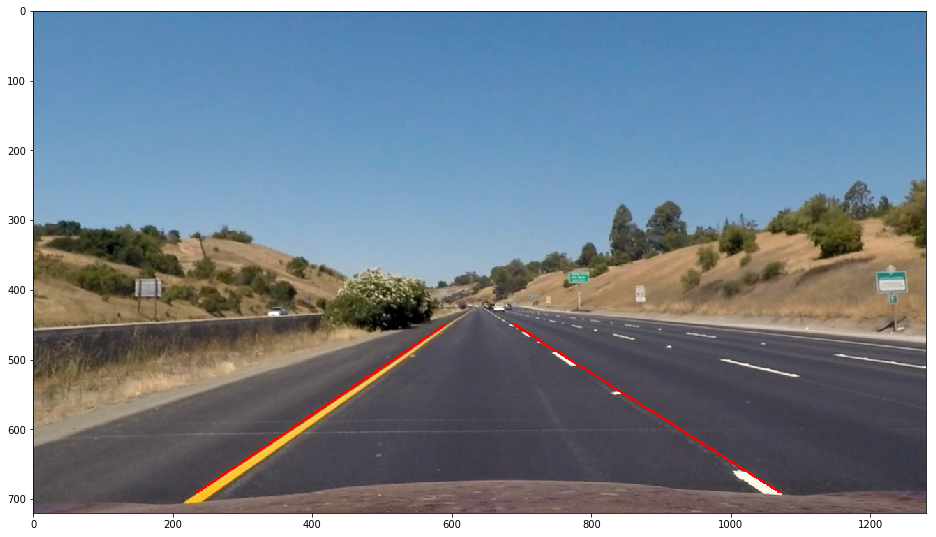

In [65]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
undistorted_image = undistortImage(img)

line1 = [ (235, 690), (590, 450) ]
line2 = [ (1070, 690), (690, 450) ]

cv2.line(undistorted_image, line1[0], line1[1], [255, 0, 0], 2)
cv2.line(undistorted_image, line2[0], line2[1], [255, 0, 0], 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.imshow(undistorted_image)
plt.savefig('perspective_transform.png')

In [66]:
img.shape
img_size = (img.shape[1], img.shape[0])

class PerspectiveTransform(object):
    def __init__(self, src_points, dest_points):
        self.M = cv2.getPerspectiveTransform(src_points, dest_points)
        self.Minv = cv2.getPerspectiveTransform(dest_points, src_points)
        
    def warp(self, image):
        return cv2.warpPerspective(image, self.M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
    def unwarp(self, image):
        return cv2.warpPerspective(image, self.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)


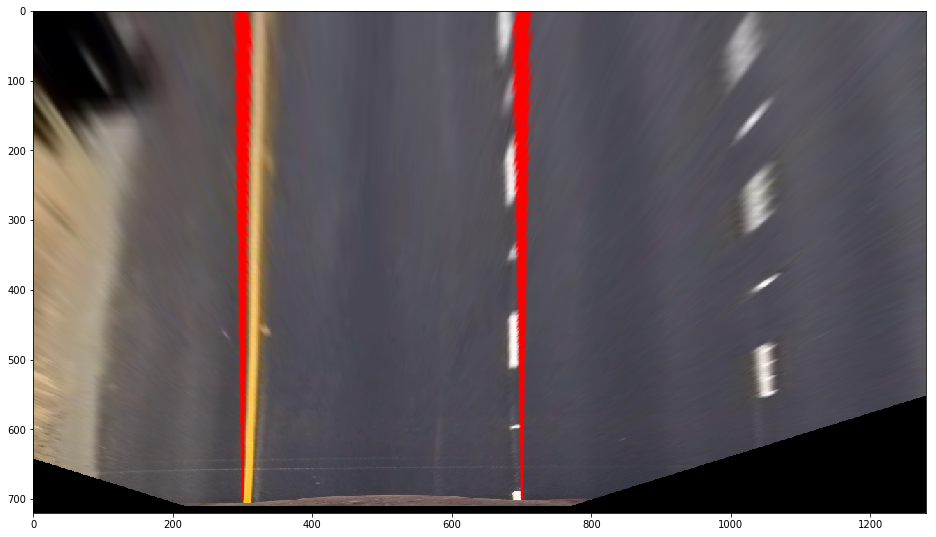

In [76]:
src_points = np.float32([
    line1[1], # upper left
    line2[1], # upper right
    line2[0], # bottom right
    line1[0], # bottom left
])

dest_points = np.float32([
    (300, 0),
    (700, 0),
    (700, 700),
    (300, 700)
])

perspective = PerspectiveTransform(src_points, dest_points)
warped = perspective.warp(undistorted_image)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.imshow(warped)

## Detect lane pixels

### Generate thresholded and transformed image

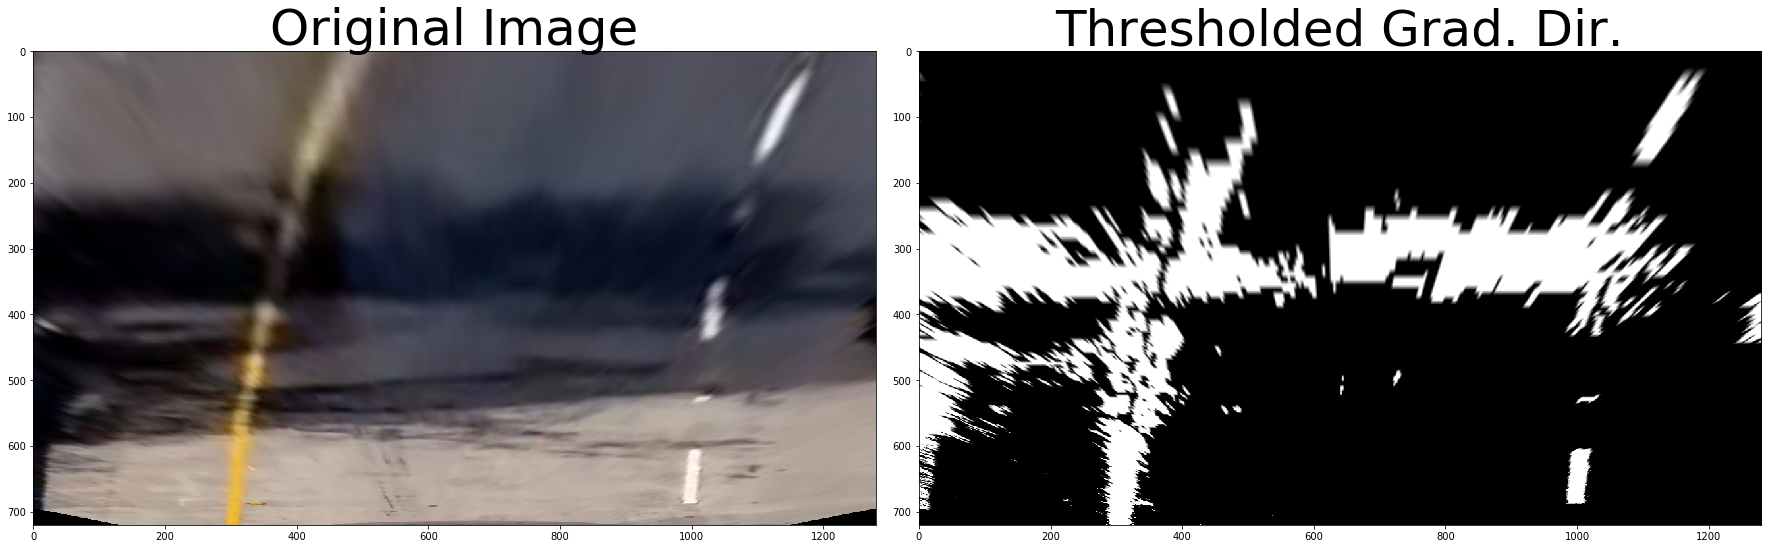

In [18]:
assert threshold is not None, "ThresholdTransform() not created"

img = mpimg.imread('./test_images/straight_lines1.jpg')
img = mpimg.imread('./test_images/test5.jpg')
undistorted_image = undistortImage(img)


warped_original = perspective.warp(undistorted_image)
thresholded_image = threshold.create_thresholded_image(undistorted_image)
thresholded_and_warped = perspective.warp(thresholded_image)

#warped_original = perspective.warp(undistorted_image)
#thresholded_and_warped = threshold.create_thresholded_image(warped_original)
#plt.imshow(warped, cmap='gray')
#thresholded_image = threshold.create_thresholded_image(warped_original)
#warped = perspective.warp(thresholded_image)
#warped = np.copy(thresholded_image)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped_original)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded_and_warped, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

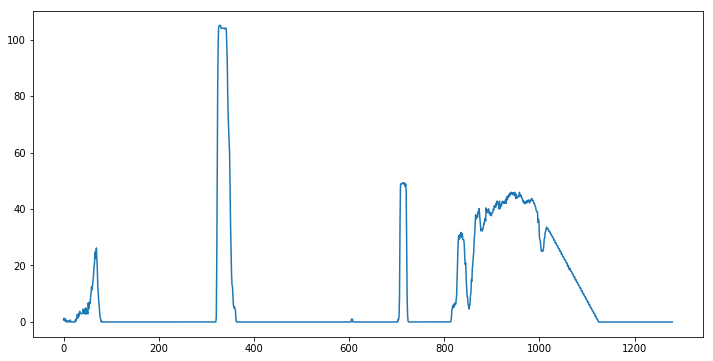

In [89]:
img = mpimg.imread('./test_images/test5.jpg')
img = mpimg.imread('./test_image_28s.jpg')

undistorted_image = undistortImage(img)


warped_original = perspective.warp(undistorted_image)
thresholded_image = threshold.create_thresholded_image(undistorted_image)
thresholded_and_warped = perspective.warp(thresholded_image)

image = thresholded_and_warped
histogram = np.sum(image[image.shape[0]*5//6:,:], axis=0)
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.plot(histogram)

In [20]:
binary_warped = np.copy(warped)

# Take histogram of bottom half of image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# create output image to draw on
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find peaks of the histogram for the left and right sides
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print("lefx={0} rightx={1}".format(leftx_base, rightx_base))

nz = image.nonzero()
print("len(nzx) = {0}".format(len(nz[0])))
print("len(nzy) = {0}".format(len(nz[1])))

lefx=960 rightx=1660
len(nzx) = 214011
len(nzy) = 214011


In [21]:
#
#

def evaluate_poly(coeffs, pts):
    return coeffs[0]*(pts**2) + coeffs[1]*pts + coeffs[2]


class PolynomialFitting(object):
    """
    Fit the lane lines in an image to a polynomial
    with sliding windows.
    """

    def __init__(self, num_windows=9, margin=100, minpix=50):
        self.num_windows = num_windows
        self.margin = margin
        self.minpix = minpix
        self.lane_center = None

    def fit_to_image(self, image):
        image = np.copy(image)
        # take histogram of bottom half of image
        histogram = np.sum(image[image.shape[0]//2:, :], axis=0)

        # Find the peak of left/right halves of image
        midpoint = np.int(histogram.shape[0]/2)
        base = (np.argmax(histogram[:midpoint]),
                np.argmax(histogram[midpoint:]) + midpoint)
        self.lane_center = (base[0], base[1])

        window_height = np.int(image.shape[0]/self.num_windows)

        # identify x,y positions of all nonzero pixels
        nonzero = image.nonzero()
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        
        # current position
        current = list(base)

        left_lane_indices = []
        right_lane_indices= []
        
        left_windows = list()
        right_windows = list()

        for window in range(self.num_windows):
            # identify window boundaries (low, high)
            win_y = (image.shape[0] - (window+1)*window_height,
                     image.shape[0] - window*window_height)
            win_xleft = (current[0] - self.margin,
                         current[0] + self.margin)
            win_xright = (current[1] - self.margin,
                          current[1] + self.margin)

            # draw the windows on the output_image
            left_windows.append( [ (win_xleft[0], win_y[0]), (win_xleft[1], win_y[1]) ])
            right_windows.append( [ (win_xright[0], win_y[0]), (win_xright[1], win_y[1]) ] )

            # identify the nonzero pixels within the window
            good_left_indices = ((nonzeroy >= win_y[0]) &
                                 (nonzeroy <  win_y[1]) &
                                 (nonzerox >= win_xleft[0]) &
                                 (nonzerox <  win_xleft[1])).nonzero()[0]
            good_right_indices = ((nonzeroy >= win_y[0]) &
                                  (nonzeroy <  win_y[1]) &
                                  (nonzerox >= win_xright[0]) &
                                  (nonzerox <  win_xright[1])).nonzero()[0]

            # append indices to the lists
            left_lane_indices.append(good_left_indices)
            right_lane_indices.append(good_right_indices)
    
            # recenter if needed (if > minpix)
            if len(good_left_indices) > self.minpix:
                current[0] = np.int(np.mean(nonzerox[good_left_indices]))
            if len(good_right_indices) > self.minpix:
                current[1] = np.int(np.mean(nonzerox[good_right_indices]))


        # save windows
        self.left_windows = left_windows
        self.right_windows = right_windows
        
        # concatenate the arrays
        left_lane_indices = np.concatenate(left_lane_indices)
        right_lane_indices = np.concatenate(right_lane_indices)

        # extract left and right lane pixel positions
        self.leftx = nonzerox[left_lane_indices]
        self.lefty = nonzeroy[left_lane_indices]
        self.rightx = nonzerox[right_lane_indices]
        self.righty = nonzeroy[right_lane_indices]

        # fit a second-order polynomial
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)


    def left_poly(self, y):
        return evaluate_poly(self.left_fit, y)

    def right_poly(self, y):
        return evaluate_poly(self.right_fit, y)
    
    def next_image_fit(self, image):
        """
        Tries to fit the current fit to the new image.
        This does not actually update the current values in this object,
        but returns an object that can be used to update this object.
        """
        nonzero = image.nonzero()    
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        
        left_eval = self.left_poly(nonzeroy)
        right_eval = self.right_poly(nonzeroy)

        left_lane_indices = ((nonzerox > (left_eval - self.margin)) & (nonzerox < (left_eval + self.margin)))
        right_lane_indices = ((nonzerox > (right_eval - self.margin)) & (nonzerox < (right_eval + self.margin)))

        # Extract left and right pixel positions
        leftx = nonzerox[left_lane_indices]
        lefty = nonzeroy[left_lane_indices]
        rightx = nonzerox[right_lane_indices]
        righty = nonzeroy[right_lane_indices]

        if len(lefty) == 0 or len(righty) == 0:
            return { "error" : "could not find any points"}

        # Fit to a 2nd order polynomial
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Find the lane center from the image
        left_center = np.sum(leftx) / len(leftx)
        right_center = np.sum(rightx) / len(rightx)

        # Find the peak of left/right halves of image
        # Calculate the center of the two peaks
        center = (left_center, right_center)

        return {
            "leftx" : leftx,
            "lefty" : lefty,
            "rightx" : rightx,
            "righty" : righty,
            "left_fit" : left_fit,
            "right_fit" : right_fit,
            "center" : (left_center, right_center)
        }

    def update(self, data):
        self.left_windows = []
        self.right_windows = []

        self.leftx = data['leftx']
        self.lefty = data['lefty']
        self.rightx = data['rightx']
        self.righty = data['righty']
        self.left_fit = data['left_fit']
        self.right_fit = data['right_fit']
        
        self.lane_center = data['center']


In [22]:
def plot_rectangle(plt, coords, color, width=2):
    pt1, pt2 = coords[0], coords[1]
    plt.vlines(pt1[0], pt1[1], pt2[1], colors=color)
    plt.vlines(pt2[0], pt1[1], pt2[1], colors=color)
    plt.hlines(pt1[1], pt1[0], pt2[0], colors=color)
    plt.hlines(pt2[1], pt1[0], pt2[0], colors=color)

(720, 0)

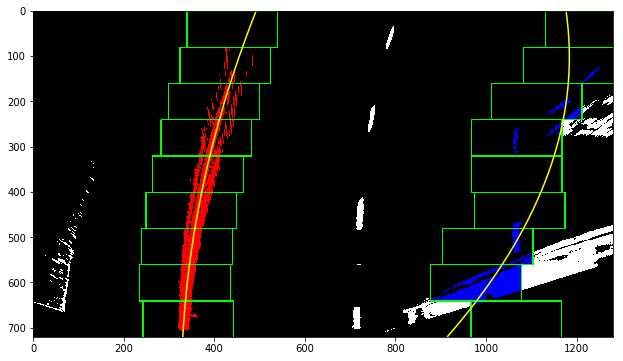

In [82]:
threshold = ThresholdTransform()

img = mpimg.imread('./test_images/test5.jpg')
#img = mpimg.imread('./test_images/test5.jpg')
img = mpimg.imread('./test_image_28s.jpg')


undistorted_image = undistortImage(img)
warped = perspective.warp(undistorted_image)
thresholded_image = threshold.create_thresholded_image(warped)


binary_warped = np.copy(thresholded_image)
pfit = PolynomialFitting(num_windows=9, margin=100, minpix=50)
pfit.fit_to_image(binary_warped)

# generate x,y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = pfit.left_poly(ploty)
right_fitx = pfit.right_poly(ploty)

out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped)))*255

out_img[pfit.lefty, pfit.leftx] = [255, 0, 0]
out_img[pfit.righty, pfit.rightx] = [0, 0, 255]

for window in pfit.left_windows:
    cv2.rectangle(out_img, window[0], window[1], (0, 255, 0), 2)
for window in pfit.right_windows:
    cv2.rectangle(out_img, window[0], window[1], (0, 255, 0), 2)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Skipping some windows using previous knowledge

(720, 0)

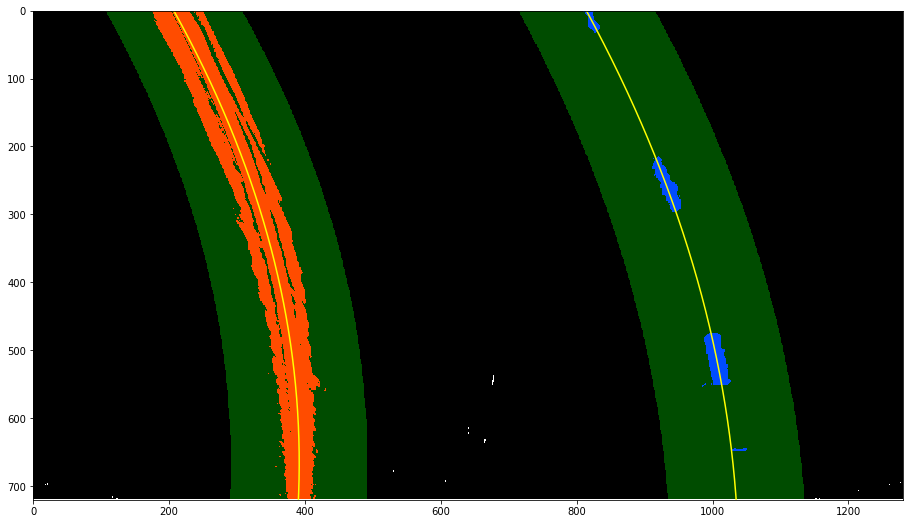

In [24]:
pfit = PolynomialFitting(num_windows=9, margin=100, minpix=50)

# undistort, warp, and threshold first image
image = mpimg.imread('./test_images/test2.jpg')
undistorted_image = undistortImage(image)
warped = perspective.warp(undistorted_image)
binary_warped = threshold.create_thresholded_image(warped)
pfit.fit_to_image(binary_warped)

# undistort, warp, and threshold second image
next_image = mpimg.imread('./test_images/test2.jpg')
next_undistorted_image = undistortImage(next_image)
next_warped = perspective.warp(next_undistorted_image)
next_binary_warped = threshold.create_thresholded_image(next_warped)

# fit the next image
pfit.update(pfit.next_image_fit(next_binary_warped))

# Generate new x, y positions for plotting
ploty = np.linspace(0, next_binary_warped.shape[0]-1, next_binary_warped.shape[0])
left_fitx = pfit.left_poly(ploty)
right_fitx = pfit.right_poly(ploty)

out_img = np.uint8(np.dstack((next_binary_warped, next_binary_warped, next_binary_warped)))*255
window_img = np.zeros_like(out_img)

# color in left/right pixels
out_img[pfit.lefty, pfit.leftx] = [255, 0, 0]
out_img[pfit.righty, pfit.rightx] = [0, 0, 255]

# generate a polygon to illustrate the search window area
# and recast the x and y points into usable format for cv2.fillPoly()
left_window1 = np.array([np.transpose(np.vstack([left_fitx-pfit.margin, ploty]))])
left_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+pfit.margin, ploty])))])
left_pts = np.hstack((left_window1, left_window2))
right_window1 = np.array([np.transpose(np.vstack([right_fitx-pfit.margin, ploty]))])
right_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+pfit.margin, ploty])))])
right_pts = np.hstack((right_window1, right_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_pts]), (0, 255, 0))
cv2.fillPoly(window_img, np.int_([right_pts]), (0, 255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## Radius of curvature calculations

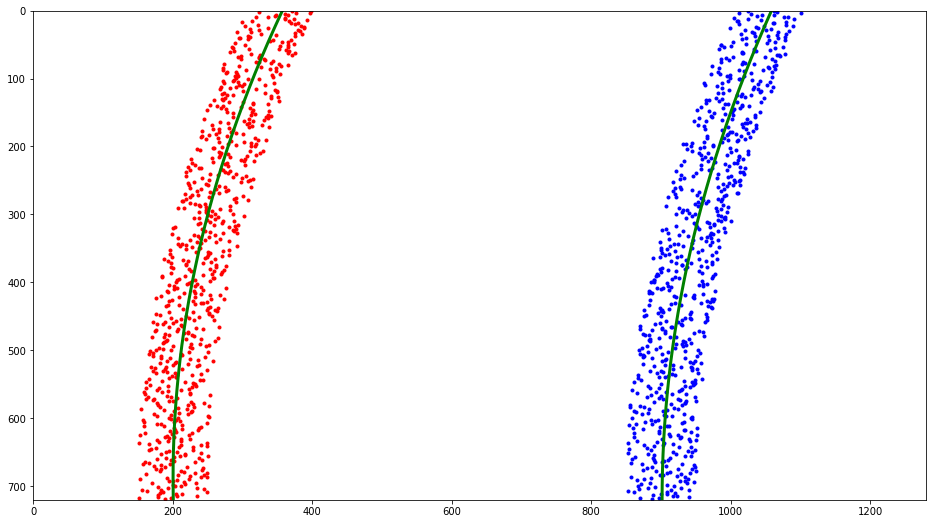

In [31]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [32]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)


1509.46077385 1651.00250276


In [33]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

495.473324984 m 542.277333665 m


In [29]:

# define conversion from pixel space to meters
ym_per_pix = 30/720  # meters per pixel in the y dimension
xm_per_pix = 3.7/700 # meters per pixel in the x dimension

# fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(pfit.lefty*ym_per_pix, pfit.leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(pfit.righty*ym_per_pix, pfit.rightx*xm_per_pix, 2)

# calculate new radii of curvature
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print(left_curverad, right_curverad)

393.860552937 501.560957596


## Putting it all together

In [34]:
# Create the Line class to hold the information for each line
# To reuse the classes, will also keep the PolynomialFitting class that fits
# both sides

class Line():
    """
    Maintains the information about a line in the lane finding code.
    There should be two instances of this class, one for the left
    side and one for the right side.
    """
    
    def __init__(self, window_size=3):
        # was the line detected in the last iteration?
        #self.detected = False
        
        self.window_size = window_size
        
        # x values of the last n fits of the line
        #self.recent_xfitted = []
        
        # average x values of the fitted line over the last n iterations
        #self.bestx = None
        
        # polynomial coefficients averaged over the last n iterations
        self.current_fit = None
        
        # polynomial coefficients for the last n iterations
        self.recent_fits = []

        # polynomial coefficients for the most recent fit
        #self.current_fit = [np.array([False])]
        
        # radius of curvature of the line in meters (using the best_fit)
        #self.radius_of_curvature = None
        
        # distance in meters of vehicle center from the line
        #self.line_base_pos = None
        
        # difference in fit coefficients from last and new fits
        #self.diffs = np.array([0,0,0], dtype='float')
        
        # x values for detected line pixels
        #self.allx = None
        
        # y values for detected line pixels
        #self.ally = None
        
    def clear(self):
        self.recent_fits = []
        self.current_fit = None
        
    def update(self, coeffs):
        if len(self.recent_fits) >= self.window_size:
            self.recent_fits = self.recent_fits[1:]
        self.recent_fits.append(coeffs)
        
        self.current_fit = np.sum(self.recent_fits, axis=0) / len(self.recent_fits)


In [35]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# preliminaries
#
# The cameraMatrix and distortionCoeffs are used when undistorting images
#
cameraMatrix, distortionCoeffs = calibration('./camera_cal/calibration*.jpg')


line1 = [ (245, 680), (550, 480) ]
line2 = [ (1060, 680), (735, 480) ]

src_points = np.float32([
    line1[1], # upper left
    line2[1], # upper right
    line2[0], # bottom right
    line1[0], # bottom left
])

dest_points = np.float32([
    (320, 0),
    (980, 0),
    (980, 720),
    (320, 720)
])

perspective = PerspectiveTransform(src_points, dest_points)
threshold = ThresholdTransform()
pfit = PolynomialFitting(num_windows=9, margin=100, minpix=50)


In [56]:
import collections

class LaneFinder():
    def __init__(self, sliding_window_depth=3):
        """
        Performs the processing to determine the two lines (left and right) for the
        traffic lane.
        
        Also maintains the history of the line (for a single lane)
        We do this by keeping the average for the past few windows (determined by
        the sliding_window_depth parameter).
        
        """
        # define conversion from pixel space to meters
        #
        # values for the curvature taken from looking at the warped images
        self.ym_per_pix = 27/720  # meters per pixel in the y dimension
        self.xm_per_pix = 3.7/650 # meters per pixel in the x dimension
        #self.ym_per_pix = 30/720  # meters per pixel in the y dimension
        #self.xm_per_pix = 3.7/700 # meters per pixel in the x dimension
      

        self.sliding_window_depth = sliding_window_depth
        self.left_lane = Line(self.sliding_window_depth)
        self.right_lane = Line(self.sliding_window_depth)
        
        # Reset the line fitting after 3 consecutive bad images
        self.bad_images_reset = 3
        
        # Number of times since the last good line
        # This is compared to some threshold value
        #   below the threshold -> reuse current line
        #   over the threshold -> search the image from scratch
        # If this is 0, then the last line was good
        # If this is -1, then the full image will be refreshed
        self.last_good_detected = -1

        self.pfit = PolynomialFitting(num_windows=9, margin=100, minpix=50)
        
        self.stats = collections.Counter()
        
        # TODO: adjust the image size, for now assume a fixed-size height
        # that is determined by the first time the image is fit
        # This is the maximum y-value for the image, that is the bottom of the image
        self.image_height = None
        self.image_width = None

    def clear_lane_info(self):
        """
        Removes any data set for the right/left lane.
        """
        self.left_lane.clear()
        self.right_lane.clear()

    def update_lane_info(self):
        """
        Updates the line (left and right) information
        """
        self.left_lane.update(self.pfit.left_fit)
        self.right_lane.update(self.pfit.right_fit)
        
        
    def get_lane_coeffs(self):
        # average the coeffs of the lane
        return (np.sum(self.left_lane.best_fit, axis=0) / float(len(self.left_lane.best_fit)),
                np.sum(self.right_lane.best_fit, axis=0) / float(len(self.right_lane.best_fit)))

    def calculate_curvature(self, left_fit, right_fit):
        """
        Calculate the curvature of the left and right lanes.
        """

        y_meters = self.ploty*self.ym_per_pix
        leftx = evaluate_poly(left_fit, self.ploty)
        rightx = evaluate_poly(right_fit, self.ploty)

        # fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(y_meters, leftx*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(y_meters, rightx*self.xm_per_pix, 2)

        # calculate new radii of curvature
        y_eval = self.ym_per_pix*self.image_height/2
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        return (left_curverad, right_curverad)
    
    def sanity_check(self, data):
        """
        Performs a sanity check on the fitted lines.
        Returns true if the lines are ok.
        Returns false if the lines do not pass the tests and should be rejected.
        """

        # Was there an error with the algorithm?
        if 'error' in data:
            print("sanity check: error: {0}".format(data['error']))
            self.stats['sanity_check::data_error'] += 1
            return False

        centers = data['center']
        
        # Check to see if we are in the center of the lane
        # Reject if we are more than 1.0 meter off-center
        center = (centers[0] + centers[1]) / 2.0
        off_center = (center - (self.image_width/2)) * self.xm_per_pix
        if abs(off_center) > 1.0:
            print("sanity_check failed: image too off center : {0}".format(off_center))
            self.stats['sanity_check::off_center'] += 1
            return False

        # Check that the two lines are roughly parallel
        # Get the curve at 10 different points, they should all be (roughly) the
        # same distance apart
        # Generate the curves, assume that they are most likely to be correct
        # near the bottom, so take that value as a baseline. If the curves
        # at the top are off by more than 2x the bottom distance, then they
        # are too far aprt.
        y = np.linspace(0, self.image_height-1, 10)

        leftx = evaluate_poly(data['left_fit'], y)
        rightx = evaluate_poly(data['right_fit'], y)
        
        bottom_distance = rightx[-1] - leftx[-1]
        
        # check that all distances are < 2*bottom_distance
        is_bottom = (rightx - leftx) > 2*bottom_distance
        if sum(is_bottom) > 1:
            print("sanity check failed: curves are not parallel")
            self.stats['sanity_check::not_parallel'] += 1
            return False
        
        
        # Check that the left/right curvatures are roughly equal
        left_curve, right_curve = self.calculate_curvature(data['left_fit'], data['right_fit'])
        
        # Let's just say that the curvature must be within 2xmin
        min_curve = min(left_curve, right_curve)
        if left_curve > 1.5*min_curve or right_curve > 1.5*min_curve:
            print("sanity check failed: curvatures are too different: {0}".format((left_curve, right_curve)))
            self.stats['sanity_check::curvature_failure'] += 1
            return False
        return True
    
    def determine_fit(self, binary_warped):
        """
        Perform the checks and determine how to use the image (it will
        have been transformed and thresholded).
        
        This implementes the control logic.
        """
        # special case for the very first run through the images
        if self.last_good_detected == -1:
            self.last_good_detected = 0
            self.pfit.fit_to_image(binary_warped)
            
            # This is the maximum y-value of the image (the bottom of the image)
            self.image_height = binary_warped.shape[0]
            self.image_width = binary_warped.shape[1]
            self.ploty = np.linspace(0, self.image_height-1, self.image_height)
            
            self.clear_lane_info()
            self.update_lane_info()
            return

        #
        # Treat this as if data has already been run through the image
        #
        data = self.pfit.next_image_fit(binary_warped)

        #
        # Control logic: what do we do with the results for this image
        #
        if self.sanity_check(data) == False:
            #
            # The sanity check failed, reject this image
            # Keep the current fit (to use to determine the lane)
            #
            self.last_good_detected += 1
            self.stats['sanity_check_failed'] += 1
        else:
            #
            # The sanity check succeeded, so reset the last_good_detected to 0
            #
            self.last_good_detected = 0
            self.stats['sanity_check_passed'] += 1
        
        #
        # Now determine what to do based on the number of
        # consecutive bad images seen
        #
        if self.last_good_detected >= self.bad_images_reset:
            #
            # We've hit the threshold for the number of consecutive
            # bad images in a row.  Do a full reset using the current frame.
            #
            self.last_good_detected = 0
            self.pfit.fit_to_image(binary_warped)

            # Clear the lane info
            self.clear_lane_info()
            self.update_lane_info()

            self.stats['image_full_reset'] += 1
            
        elif self.last_good_detected > 0:
            #
            # We've found a bad image, but it's under the threshold
            # Continue using the previous information
            # Nothing to do, do not update the fit object or lane info
            self.stats['image_skipped'] += 1
            pass

        elif self.last_good_detected == 0:
            #
            # This image is good, update the information
            #
            self.pfit.update(data)            
            self.update_lane_info()
            self.stats['image_ok'] += 1

    def process_image(self, image):
        """
        Process a single video frame
        Returns the final output (image which we draw on)
        """
        undistorted_image = undistortImage(image)
        warped = perspective.warp(undistorted_image)
        binary_warped = threshold.create_thresholded_image(warped)
        
        # Now that the image is ready to be used, run it through
        # the proper logic (sanity checks etc...)
        self.determine_fit(binary_warped)
                
        # ok, at this point the lines should have the proper coefficients
        # so use those to draw the lines on the image
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
        # recast x, y points into usuable format for cv2.fillPoly()
        # Get the average coefficients
        left_coeff, right_coeff = self.left_lane.current_fit, self.right_lane.current_fit
        left_fitx = evaluate_poly(left_coeff, self.ploty)
        right_fitx = evaluate_poly(right_coeff, self.ploty)
    
        pts_left = np.array([np.transpose(np.vstack([left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
    
        # draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
        # warp the blank back to original image space
        newwarp = perspective.unwarp(color_warp)

        final_img = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        left_curve, right_curve = self.calculate_curvature(self.pfit.left_fit, self.pfit.right_fit)
        cv2.putText(final_img,
                    'radius of curvature = {0:.1f} m'.format(min(left_curve,right_curve)),
                    (100, 50), font, 1.0, (255, 255, 255), 2)
        center = (self.pfit.lane_center[0] + self.pfit.lane_center[1]) / 2.0
        off_center = (center - (self.image_width/2)) * self.xm_per_pix
        if off_center > 0:
            off_center_text = "Vehicle is left of center by {0:.1f} m".format(off_center)
        elif off_center < 0:
            off_center_text = "Vehicle is right of center by {0:.1f} m".format(-off_center)
        else:
            off_center_text = ""
            
        cv2.putText(final_img,
                    off_center_text,
                    (100, 100), font, 1.0, (255, 255, 255), 2)
        return final_img
    
lanefinder = LaneFinder(5)

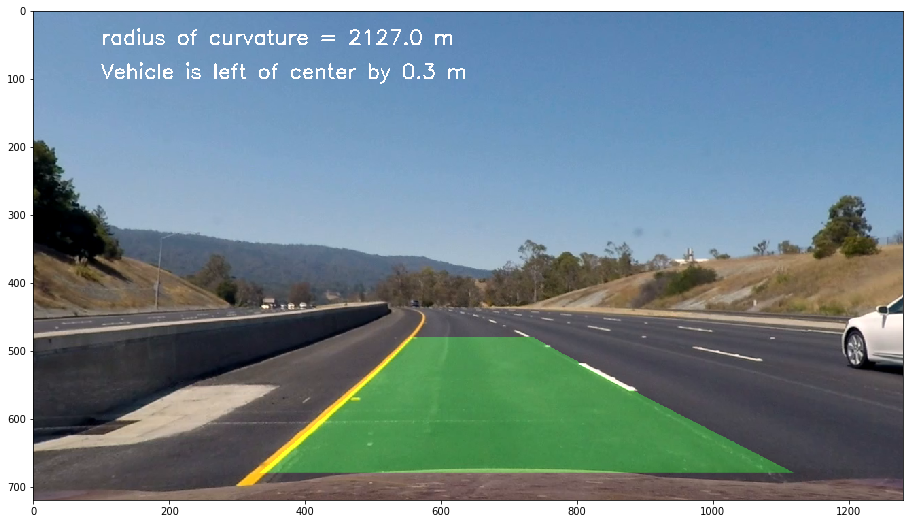

In [58]:
lanefinder = LaneFinder(5)
clip = VideoFileClip('./project_video.mp4')
fps = clip.fps
#clip_image = clip.get_frame(6)
#out = lanefinder.process_image(clip_image)
#left_curve, right_curve = lanefinder.calculate_curvature(lanefinder.pfit.left_fit, lanefinder.pfit.right_fit)
#plt.imshow(out)

clip_image = clip.get_frame(6)
out = lanefinder.process_image(clip_image)
left_curve, right_curve = lanefinder.calculate_curvature(lanefinder.pfit.left_fit, lanefinder.pfit.right_fit)
plt.imshow(out)

In [59]:
lanefinder = LaneFinder(5)
test_output = "./project_output.mp4"
clip1 = VideoFileClip('./project_video.mp4')
test_clip1 = clip1.fl_image(lanefinder.process_image)
%time test_clip1.write_videofile(test_output, audio=False)
print(lanefinder.stats)

[MoviePy] >>>> Building video ./project_output.mp4
[MoviePy] Writing video ./project_output.mp4


  0%|          | 1/1261 [00:00<03:28,  6.06it/s]

sanity check failed: curvatures are too different: (2895.4144890267708, 52780.840205921006)


  0%|          | 2/1261 [00:00<03:26,  6.10it/s]

sanity check failed: curvatures are too different: (2257.4141293834828, 1416.2161742259693)


  1%|          | 9/1261 [00:01<03:12,  6.49it/s]

sanity check failed: curvatures are too different: (1405.1808800768661, 4607.6192099021282)
sanity check failed: curvatures are too different: (1515.6726525320087, 2866.758587152674)


  1%|          | 11/1261 [00:01<03:14,  6.41it/s]

sanity check failed: curvatures are too different: (1638.7296247737499, 5066.1892317933625)
sanity check failed: curvatures are too different: (1438.3226598555134, 15852.705323682452)


  1%|          | 13/1261 [00:02<03:12,  6.49it/s]

sanity check failed: curvatures are too different: (1429.3127178097252, 26147.162487547583)


  1%|▏         | 18/1261 [00:02<03:15,  6.36it/s]

sanity check failed: curvatures are too different: (1231.6296006877963, 2340.4428376275955)
sanity check failed: curvatures are too different: (1140.7395954872277, 3198.0990030380644)


  2%|▏         | 20/1261 [00:03<03:20,  6.18it/s]

sanity check failed: curvatures are too different: (1248.7491067493033, 5325.9203403330393)
sanity check failed: curvatures are too different: (1439.3500852781908, 8178.2187384901645)


  2%|▏         | 24/1261 [00:03<03:16,  6.29it/s]

sanity check failed: curvatures are too different: (4598.1968033192006, 2396.5118823976804)
sanity check failed: curvatures are too different: (6260.5524634936382, 3290.4693301651819)


  2%|▏         | 25/1261 [00:03<03:25,  6.02it/s]

sanity check failed: curvatures are too different: (7612.5915844740484, 351.78820349491019)
sanity check failed: curvatures are too different: (29224.286896806181, 1252.7283559878995)


  2%|▏         | 28/1261 [00:04<03:25,  6.01it/s]

sanity check failed: curvatures are too different: (12435.450750643118, 1110.8019930156156)
sanity check failed: curvatures are too different: (11567.832865004868, 1370.2319247999374)


  2%|▏         | 29/1261 [00:04<03:23,  6.06it/s]

sanity check failed: curvatures are too different: (8837.3392190137929, 1330.4243339062728)


  2%|▏         | 30/1261 [00:04<03:45,  5.45it/s]

sanity check failed: curvatures are too different: (2573.5664776336766, 1282.0650057720065)


  3%|▎         | 34/1261 [00:05<03:24,  5.99it/s]

sanity check failed: curvatures are too different: (1484.3767212678247, 15550.368091234352)
sanity check failed: curvatures are too different: (1399.943592300481, 21974.84405019859)


  3%|▎         | 36/1261 [00:05<03:23,  6.02it/s]

sanity check failed: curvatures are too different: (1419.6215578839679, 16904.263231791807)
sanity check failed: curvatures are too different: (1451.8371244817329, 232291.87696831863)


  3%|▎         | 38/1261 [00:06<03:20,  6.11it/s]

sanity check failed: curvatures are too different: (1420.2702002443118, 22158.22802007771)


  3%|▎         | 44/1261 [00:07<03:43,  5.46it/s]

sanity check failed: curvatures are too different: (989.00978334408319, 1665.0053045163368)


  4%|▎         | 46/1261 [00:07<03:44,  5.42it/s]

sanity check failed: curvatures are too different: (1021.7340510553825, 24286.682442551519)
sanity check failed: curvatures are too different: (1046.3725951620565, 12333.092060356232)


  4%|▍         | 48/1261 [00:08<03:43,  5.44it/s]

sanity check failed: curvatures are too different: (1114.2968928445755, 16770.089292287372)
sanity check failed: curvatures are too different: (1138.4131243884756, 20308.340499241142)


  4%|▍         | 50/1261 [00:08<03:34,  5.64it/s]

sanity check failed: curvatures are too different: (1111.8358832104793, 11395.282862687332)
sanity check failed: curvatures are too different: (1111.7986702758169, 2483.1409480558036)


  5%|▍         | 59/1261 [00:10<03:36,  5.54it/s]

sanity check failed: curvatures are too different: (1731.4075595728868, 12559.043601524509)
sanity check failed: curvatures are too different: (2061.3764094829207, 6232.5260290044371)


  5%|▍         | 60/1261 [00:10<03:54,  5.11it/s]

sanity check failed: curvatures are too different: (2749.1297418119489, 20786.198566442996)


  5%|▍         | 63/1261 [00:10<03:33,  5.62it/s]

sanity check failed: curvatures are too different: (6586.5070871789976, 3489.0757691267613)
sanity check failed: curvatures are too different: (13168.748593818782, 545.76820411248741)


  5%|▌         | 64/1261 [00:10<03:34,  5.58it/s]

sanity check failed: curvatures are too different: (11591.443219736795, 1521.8528668243944)
sanity check failed: curvatures are too different: (13887.990157900955, 1526.428959478194)


  5%|▌         | 66/1261 [00:11<03:27,  5.75it/s]

sanity check failed: curvatures are too different: (4000.6595046691564, 1574.3839772943522)
sanity check failed: curvatures are too different: (3513.0615068766833, 1928.4299615669204)


  6%|▌         | 70/1261 [00:12<03:33,  5.57it/s]

sanity check failed: curvatures are too different: (1505.5019294979597, 2358.7027980776006)
sanity check failed: curvatures are too different: (1336.7756260591375, 2835.9460660111727)


  6%|▌         | 76/1261 [00:13<03:18,  5.98it/s]

sanity check failed: curvatures are too different: (1309.9558624109425, 5516.9986724207465)


  6%|▋         | 80/1261 [00:13<03:17,  5.97it/s]

sanity check failed: curvatures are too different: (5256.9966212531554, 1779.2288603357904)
sanity check failed: curvatures are too different: (4114.4788182562261, 1579.2810266359279)


  6%|▋         | 81/1261 [00:13<03:51,  5.09it/s]

sanity check failed: curvatures are too different: (5634.575867274908, 1797.2162818249142)


  7%|▋         | 82/1261 [00:14<04:03,  4.85it/s]

sanity check failed: curvatures are too different: (4520.6393436115686, 1813.8639646414395)


  7%|▋         | 83/1261 [00:14<04:14,  4.64it/s]

sanity check failed: curvatures are too different: (3661.8824557803296, 28224.652833432778)


  7%|▋         | 86/1261 [00:14<03:42,  5.28it/s]

sanity check failed: curvatures are too different: (3292.3606743327168, 6882.8906202876578)
sanity check failed: curvatures are too different: (3811.2101393857288, 8089.4330204662119)


  7%|▋         | 88/1261 [00:15<03:30,  5.56it/s]

sanity check failed: curvatures are too different: (3656.7290992807807, 10755.138138618882)
sanity check failed: curvatures are too different: (3516.6704507639515, 2032.3466473345948)


  7%|▋         | 89/1261 [00:15<03:25,  5.70it/s]

sanity check failed: curvatures are too different: (3346.4405879005521, 1144.2142787183782)
sanity check failed: curvatures are too different: (3873.7938661366916, 1300.3584154389796)


  7%|▋         | 92/1261 [00:15<03:23,  5.75it/s]

sanity check failed: curvatures are too different: (5215.12048411655, 1489.7670279112308)
sanity check failed: curvatures are too different: (4989.3501388912855, 1719.2431203572212)


  8%|▊         | 95/1261 [00:16<03:16,  5.93it/s]

sanity check failed: curvatures are too different: (1698.5863806971286, 2978.6240302471379)
sanity check failed: curvatures are too different: (1670.4544000482581, 3877.6296543533499)


  8%|▊         | 96/1261 [00:16<03:20,  5.81it/s]

sanity check failed: curvatures are too different: (1548.0675449012394, 7457.296406735627)
sanity_check failed: image too off center : -1.6434899567140329


  8%|▊         | 99/1261 [00:17<03:16,  5.91it/s]

sanity_check failed: image too off center : -1.6574521374145046
sanity_check failed: image too off center : -1.649812191875716


  8%|▊         | 101/1261 [00:17<03:14,  5.98it/s]

sanity check failed: curvatures are too different: (1738.9080992333706, 3247.0352398532837)
sanity check failed: curvatures are too different: (1576.9714676965405, 3035.2632770568875)


  8%|▊         | 103/1261 [00:17<03:15,  5.92it/s]

sanity check failed: curvatures are too different: (2117.6379940079555, 1195.302590935697)
sanity check failed: curvatures are too different: (2567.2059453381466, 1229.3763151929115)


  8%|▊         | 105/1261 [00:18<03:18,  5.82it/s]

sanity check failed: curvatures are too different: (2327.3917580804164, 1195.4529113647036)
sanity check failed: curvatures are too different: (2185.3145896703536, 1190.8390998028708)


  8%|▊         | 107/1261 [00:18<03:14,  5.93it/s]

sanity check failed: curvatures are too different: (2241.3169433587641, 1389.4613105163382)
sanity check failed: curvatures are too different: (2335.4823531291113, 1495.9351545589445)


  9%|▉         | 111/1261 [00:19<03:15,  5.88it/s]

sanity check failed: curvatures are too different: (2036.9299497295619, 6237.0132196516925)
sanity check failed: curvatures are too different: (1814.4847092096697, 11130.029401300948)


  9%|▉         | 112/1261 [00:19<03:21,  5.70it/s]

sanity check failed: curvatures are too different: (1805.2108315084588, 11643.851456794835)
sanity check failed: curvatures are too different: (2054.9355767048901, 7072.8875557436595)


 10%|▉         | 121/1261 [00:20<03:17,  5.77it/s]

sanity check failed: curvatures are too different: (1433.2663931256941, 9715.0268870110231)
sanity check failed: curvatures are too different: (1245.1612189861567, 5750.0009136449689)

 10%|▉         | 124/1261 [00:21<03:20,  5.67it/s]


sanity check failed: curvatures are too different: (1192.8317136434061, 7847.1717272684828)
sanity check failed: curvatures are too different: (1165.6004127867541, 39021.296139172911)


 10%|▉         | 126/1261 [00:21<03:16,  5.78it/s]

sanity check failed: curvatures are too different: (1351.8652534489909, 7576.6816144324348)
sanity check failed: curvatures are too different: (1442.9791837120715, 4544.0707466174099)


 11%|█         | 135/1261 [00:23<03:27,  5.43it/s]

sanity check failed: curvatures are too different: (1557.2871205503736, 2478.8935491124053)


 11%|█         | 140/1261 [00:24<03:17,  5.67it/s]

sanity check failed: curvatures are too different: (2991.412202546644, 4701.8351840952291)
sanity check failed: curvatures are too different: (4744.2927308528879, 1827.2042970416821)


 11%|█         | 141/1261 [00:24<03:33,  5.24it/s]

sanity check failed: curvatures are too different: (3609.0328113317528, 1696.777482328705)
sanity check failed: curvatures are too different: (2483.4895058166144, 1484.709637792917)


 12%|█▏        | 147/1261 [00:25<03:22,  5.50it/s]

sanity check failed: curvatures are too different: (1507.0287522592712, 38494.977262740817)
sanity check failed: curvatures are too different: (1210.7709127275464, 16118.819098886554)


 12%|█▏        | 148/1261 [00:25<03:21,  5.51it/s]

sanity check failed: curvatures are too different: (1286.7010400198976, 6220.316939417733)
sanity check failed: curvatures are too different: (1512.8290788322063, 38442.906947717544)


 12%|█▏        | 151/1261 [00:26<03:11,  5.80it/s]

sanity check failed: curvatures are too different: (1867.6203734883247, 18325.183601469947)


 12%|█▏        | 153/1261 [00:26<03:06,  5.93it/s]

sanity check failed: curvatures are too different: (3702.6803275966668, 2194.5474067282307)
sanity check failed: curvatures are too different: (2133.1235924723865, 4221.9736058550352)


 12%|█▏        | 156/1261 [00:27<03:27,  5.33it/s]

sanity check failed: curvatures are too different: (2599.4179654825271, 1688.9411183530917)
sanity check failed: curvatures are too different: (2779.5466758101234, 1478.7412080036077)


 13%|█▎        | 158/1261 [00:27<03:44,  4.91it/s]

sanity check failed: curvatures are too different: (2652.1548560527503, 1229.1547811104888)


 13%|█▎        | 159/1261 [00:28<03:50,  4.78it/s]

sanity check failed: curvatures are too different: (2315.6735322986351, 5917.0051073372888)


 13%|█▎        | 163/1261 [00:28<03:21,  5.46it/s]

sanity check failed: curvatures are too different: (1918.2716454717997, 3125.0631548742094)
sanity check failed: curvatures are too different: (1962.2233389133171, 4102.4600079346419)


 13%|█▎        | 164/1261 [00:28<03:23,  5.40it/s]

sanity check failed: curvatures are too different: (2386.1956742055936, 7087.5794179971344)


 13%|█▎        | 169/1261 [00:29<03:08,  5.80it/s]

sanity check failed: curvatures are too different: (1707.2432366762646, 2871.9791932643093)
sanity check failed: curvatures are too different: (1684.4907569770799, 4023.4681285957558)


 13%|█▎        | 170/1261 [00:29<03:19,  5.46it/s]

sanity check failed: curvatures are too different: (1638.1526821816697, 5478.1062629389635)


 14%|█▎        | 173/1261 [00:30<03:11,  5.68it/s]

sanity check failed: curvatures are too different: (1775.7254163770574, 4873.9822446541712)


 14%|█▍        | 177/1261 [00:31<03:03,  5.89it/s]

sanity check failed: curvatures are too different: (2125.9977651065155, 1259.754880145533)
sanity check failed: curvatures are too different: (3022.1822503676431, 1519.3973871986864)


 14%|█▍        | 178/1261 [00:31<03:11,  5.67it/s]

sanity check failed: curvatures are too different: (3555.5297396957585, 1334.011966059556)
sanity check failed: curvatures are too different: (8052.64336556953, 1177.9990274508052)


 14%|█▍        | 180/1261 [00:31<03:05,  5.82it/s]

sanity check failed: curvatures are too different: (12327.285260602208, 1015.6505658067109)


 14%|█▍        | 181/1261 [00:31<03:31,  5.10it/s]

sanity check failed: curvatures are too different: (75102.463267654122, 895.81443118059815)


 15%|█▍        | 183/1261 [00:32<03:20,  5.38it/s]

sanity check failed: curvatures are too different: (12080.188628664237, 903.23469034196364)
sanity check failed: curvatures are too different: (5373.7129569552117, 984.8064065842301)


 15%|█▍        | 184/1261 [00:32<03:18,  5.42it/s]

sanity check failed: curvatures are too different: (2742.7058485655261, 6360.3989572423961)
sanity check failed: curvatures are too different: (1616.7051643986565, 6851.9585879647111)


 15%|█▍        | 187/1261 [00:32<03:02,  5.90it/s]

sanity check failed: curvatures are too different: (1305.7498713411478, 11281.55497761522)


 16%|█▌        | 197/1261 [00:34<03:07,  5.66it/s]

sanity check failed: curvatures are too different: (1370.602558704408, 2379.0004429375435)
sanity check failed: curvatures are too different: (1555.8107808730697, 3772.4096279076125)


 16%|█▌        | 199/1261 [00:34<03:01,  5.84it/s]

sanity check failed: curvatures are too different: (1597.3032471126121, 3421.2920641139053)
sanity check failed: curvatures are too different: (1525.9923718643188, 3075.60953183419)


 16%|█▌        | 203/1261 [00:35<03:01,  5.84it/s]

sanity check failed: curvatures are too different: (2102.9109278806545, 117443.99874945269)


 16%|█▋        | 208/1261 [00:36<03:08,  5.59it/s]

sanity check failed: curvatures are too different: (1953.9544939927125, 1172.0228256371929)


 17%|█▋        | 210/1261 [00:36<02:59,  5.84it/s]

sanity check failed: curvatures are too different: (1821.6432240224692, 581.24967176463645)
sanity check failed: curvatures are too different: (1908.0560336298474, 3435.8110859595035)


 17%|█▋        | 213/1261 [00:37<03:33,  4.92it/s]

sanity check failed: curvatures are too different: (2068.0465803520096, 363.15346704523733)


 18%|█▊        | 223/1261 [00:39<03:13,  5.35it/s]

sanity check failed: curvatures are too different: (1493.0810193445716, 950.31551674433479)
sanity check failed: curvatures are too different: (1701.5644324489358, 1005.1456364868029)


 18%|█▊        | 225/1261 [00:39<03:22,  5.13it/s]

sanity check failed: curvatures are too different: (1739.2836118324167, 666.82452221415883)
sanity check failed: curvatures are too different: (1861.2741289417279, 5737.9246044849169)


 18%|█▊        | 227/1261 [00:40<03:26,  5.02it/s]

sanity check failed: curvatures are too different: (1909.3802341116118, 12426.078072061937)
sanity check failed: curvatures are too different: (1697.7065345268802, 4272.573201714371)


 18%|█▊        | 229/1261 [00:40<03:16,  5.24it/s]

sanity check failed: curvatures are too different: (1615.872572333675, 3382.2485705762542)


 18%|█▊        | 233/1261 [00:41<03:09,  5.44it/s]

sanity check failed: curvatures are too different: (1878.3768821694121, 3784.3854981969685)


 19%|█▊        | 234/1261 [00:41<03:19,  5.14it/s]

sanity check failed: curvatures are too different: (2122.3863490660642, 3615.2117233599984)
sanity check failed: curvatures are too different: (2098.1651357606725, 6168.1333599985301)


 19%|█▉        | 237/1261 [00:42<03:15,  5.23it/s]

sanity check failed: curvatures are too different: (3272.4966030773089, 389.52052164949646)
sanity check failed: curvatures are too different: (5738.5071336151932, 1348.5006298670583)


 19%|█▉        | 239/1261 [00:42<03:11,  5.32it/s]

sanity check failed: curvatures are too different: (4821.6165199446641, 1484.4888226093872)


 19%|█▉        | 240/1261 [00:42<03:15,  5.23it/s]

sanity check failed: curvatures are too different: (3711.7248621956755, 1340.2710843895538)
sanity check failed: curvatures are too different: (2835.8522614447402, 1375.4241579383995)


 19%|█▉        | 242/1261 [00:43<03:13,  5.28it/s]

sanity check failed: curvatures are too different: (2754.7967354310995, 1460.8993963591274)
sanity check failed: curvatures are too different: (2309.0868118937788, 1321.9442648346026)


 19%|█▉        | 244/1261 [00:43<03:00,  5.62it/s]

sanity check failed: curvatures are too different: (2148.1337429382124, 1410.1481474900245)
sanity check failed: curvatures are too different: (2033.9616218651806, 3686.976568053441)


 20%|█▉        | 248/1261 [00:44<02:59,  5.63it/s]

sanity check failed: curvatures are too different: (1825.7708682764387, 3649.2182022278234)
sanity check failed: curvatures are too different: (2273.5717102740982, 5008.3762635002422)


 20%|█▉        | 249/1261 [00:44<03:16,  5.16it/s]

sanity check failed: curvatures are too different: (2586.5602578331627, 283.16221110599764)


 20%|█▉        | 251/1261 [00:44<03:12,  5.24it/s]

sanity check failed: curvatures are too different: (2891.7066879633758, 1556.7173628541673)
sanity check failed: curvatures are too different: (3090.323177987379, 1269.3185976879147)


 20%|█▉        | 252/1261 [00:45<03:12,  5.25it/s]

sanity check failed: curvatures are too different: (2235.3915166323591, 1274.3412765813739)


 20%|██        | 256/1261 [00:45<03:02,  5.51it/s]

sanity check failed: curvatures are too different: (1964.5947955285797, 1188.1034970979945)
sanity check failed: curvatures are too different: (1967.3069068722671, 1166.4836729843371)


 21%|██        | 260/1261 [00:46<03:00,  5.55it/s]

sanity check failed: curvatures are too different: (2497.2674530624163, 477.03034238788655)


 21%|██        | 265/1261 [00:47<02:57,  5.60it/s]

sanity check failed: curvatures are too different: (2972.4607979747593, 1858.7208125782145)


 21%|██▏       | 271/1261 [00:48<03:00,  5.47it/s]

sanity check failed: curvatures are too different: (1828.0275338672707, 1161.5856355472881)


 22%|██▏       | 272/1261 [00:48<03:12,  5.14it/s]

sanity check failed: curvatures are too different: (2083.077369386242, 1298.2512244303693)
sanity check failed: curvatures are too different: (2357.9507683324005, 949.09667631637797)

 22%|██▏       | 281/1261 [00:50<02:51,  5.73it/s]


sanity check failed: curvatures are too different: (1764.2431058444943, 19274.275366638482)


 22%|██▏       | 282/1261 [00:50<03:07,  5.23it/s]

sanity check failed: curvatures are too different: (1883.5209826736484, 3785.543911135801)


 23%|██▎       | 285/1261 [00:51<02:56,  5.53it/s]

sanity check failed: curvatures are too different: (3082.1461302584903, 15326.103192813247)


 23%|██▎       | 286/1261 [00:51<03:07,  5.20it/s]

sanity check failed: curvatures are too different: (4279.0888895803582, 999.47272693200841)
sanity check failed: curvatures are too different: (5850.0814755225001, 2145.9016677025234)


 23%|██▎       | 289/1261 [00:52<03:06,  5.20it/s]

sanity check failed: curvatures are too different: (4205.8456949177234, 2705.5706202169349)


 23%|██▎       | 294/1261 [00:52<02:45,  5.84it/s]

sanity check failed: curvatures are too different: (2656.9969081963391, 6019.8304736088776)
sanity check failed: curvatures are too different: (3729.7877751240385, 9076.0099499158332)


 23%|██▎       | 295/1261 [00:53<02:48,  5.75it/s]

sanity check failed: curvatures are too different: (7661.0223154340829, 22070.17720966959)
sanity check failed: curvatures are too different: (2781.8118834502807, 8151.2728699374893)


 24%|██▎       | 297/1261 [00:53<02:58,  5.39it/s]

sanity check failed: curvatures are too different: (4483.9582517129966, 1434564.8568799712)
sanity check failed: curvatures are too different: (8493.5222361685119, 1987.7802001235107)


 24%|██▍       | 300/1261 [00:53<02:45,  5.80it/s]

sanity check failed: curvatures are too different: (17417.313415939116, 2419.035234706093)
sanity check failed: curvatures are too different: (15961.353053824558, 2762.7931521624282)


 24%|██▍       | 302/1261 [00:54<02:43,  5.88it/s]

sanity check failed: curvatures are too different: (4925.0908550470895, 2240.3987327739924)
sanity check failed: curvatures are too different: (4411.1277748013235, 2337.8427911397475)


 24%|██▍       | 303/1261 [00:54<02:42,  5.91it/s]

sanity check failed: curvatures are too different: (4736.3274507961896, 2425.5399253165383)
sanity check failed: curvatures are too different: (3567.2429272391732, 2060.7214120854815)


 24%|██▍       | 306/1261 [00:54<02:42,  5.87it/s]

sanity check failed: curvatures are too different: (2914.7328936769281, 14264.88625002984)
sanity check failed: curvatures are too different: (1999.8955355208404, 19109.676694260495)


 24%|██▍       | 308/1261 [00:55<02:40,  5.94it/s]

sanity check failed: curvatures are too different: (2049.3319434358514, 10538.331074598034)
sanity check failed: curvatures are too different: (2334.0977297952081, 5367.72288377327)


 25%|██▍       | 309/1261 [00:55<02:38,  6.01it/s]

sanity check failed: curvatures are too different: (3800.1984604471154, 8934.8344513143493)
sanity check failed: curvatures are too different: (10077.644310949176, 3331.6556354801905)


 25%|██▍       | 311/1261 [00:55<02:41,  5.90it/s]

sanity check failed: curvatures are too different: (27039.86180028088, 4663.4932168428613)


 25%|██▍       | 312/1261 [00:56<02:55,  5.41it/s]

sanity check failed: curvatures are too different: (26694.724639657645, 6647.1221188650534)


 25%|██▌       | 316/1261 [00:56<02:46,  5.69it/s]

sanity check failed: curvatures are too different: (10011.259170312598, 25576.523371006515)


 25%|██▌       | 318/1261 [00:57<02:39,  5.90it/s]

sanity check failed: curvatures are too different: (5195.0629972715442, 1440.1379298356699)
sanity check failed: curvatures are too different: (6331.0402097541755, 1304.1823528375435)


 25%|██▌       | 319/1261 [00:57<02:58,  5.26it/s]

sanity check failed: curvatures are too different: (4329.7911625369461, 1392.6323649098949)
sanity check failed: curvatures are too different: (8754.6321935783617, 1304.154879224383)


 25%|██▌       | 321/1261 [00:57<03:00,  5.20it/s]

sanity check failed: curvatures are too different: (179210.23982084039, 1449.4563944839922)


 26%|██▌       | 322/1261 [00:57<03:11,  4.89it/s]

sanity check failed: curvatures are too different: (19540.813403103915, 4109.1413076654562)


 26%|██▌       | 325/1261 [00:58<02:45,  5.67it/s]

sanity check failed: curvatures are too different: (29631.846161973826, 6351.4396225907576)


 26%|██▌       | 326/1261 [00:58<02:57,  5.28it/s]

sanity check failed: curvatures are too different: (17479.628434931041, 5313.3240815288191)
sanity check failed: curvatures are too different: (67824.721812361284, 4255.95861118417)


 26%|██▌       | 329/1261 [00:59<02:45,  5.63it/s]

sanity check failed: curvatures are too different: (16165.272286779278, 2798.6050428865392)
sanity check failed: curvatures are too different: (5155.4732677650627, 87872.976263675009)


 26%|██▌       | 330/1261 [00:59<02:43,  5.69it/s]

sanity check failed: curvatures are too different: (7118.6676858734081, 12217.873283926338)


 26%|██▋       | 333/1261 [00:59<02:32,  6.07it/s]

sanity check failed: curvatures are too different: (11766.020398514434, 4986.7282240753193)


 27%|██▋       | 338/1261 [01:00<02:29,  6.17it/s]

sanity check failed: curvatures are too different: (7260.2369921227128, 4599.9855500517651)


 27%|██▋       | 340/1261 [01:00<02:30,  6.12it/s]

sanity check failed: curvatures are too different: (48337.551007467431, 10666.564635700848)
sanity check failed: curvatures are too different: (17697.144203529828, 3763.8698107975943)


 27%|██▋       | 342/1261 [01:01<02:30,  6.09it/s]

sanity check failed: curvatures are too different: (6387.8300594693383, 3536.4254802596574)
sanity_check failed: image too off center : -1.4173024763562159


 27%|██▋       | 343/1261 [01:01<02:29,  6.12it/s]

sanity_check failed: image too off center : -1.4423365473746583
sanity_check failed: image too off center : -1.4536599777890122


 27%|██▋       | 346/1261 [01:01<02:32,  6.01it/s]

sanity check failed: curvatures are too different: (6670.5015362138474, 1929.0715446821787)
sanity check failed: curvatures are too different: (9933.8685109638409, 829.45452955743917)


 28%|██▊       | 349/1261 [01:02<02:33,  5.95it/s]

sanity check failed: curvatures are too different: (4180.2116881621496, 7591.3020207394529)
sanity check failed: curvatures are too different: (4035.7531477948314, 8082.1979096454361)


 28%|██▊       | 351/1261 [01:02<02:33,  5.93it/s]

sanity check failed: curvatures are too different: (3134.3147632602486, 12532.912126996791)
sanity check failed: curvatures are too different: (4418.0556911707454, 37596.040505924284)


 28%|██▊       | 352/1261 [01:02<02:32,  5.96it/s]

sanity check failed: curvatures are too different: (6238.7038829026133, 14985.901014759425)
sanity check failed: curvatures are too different: (7390.7229257751942, 1248.7020580506696)


 28%|██▊       | 355/1261 [01:03<02:35,  5.83it/s]

sanity check failed: curvatures are too different: (11972.506744788139, 739.9153562676878)
sanity check failed: curvatures are too different: (23141.834570912826, 867.50695371206245)


 28%|██▊       | 357/1261 [01:03<02:32,  5.92it/s]

sanity check failed: curvatures are too different: (32950.099880014655, 975.68878484362347)
sanity check failed: curvatures are too different: (22721.679678846715, 1208.1918463077211)


 28%|██▊       | 359/1261 [01:04<02:29,  6.04it/s]

sanity check failed: curvatures are too different: (75195.184704126848, 1146.6963281544906)


 29%|██▊       | 361/1261 [01:04<02:28,  6.07it/s]

sanity check failed: curvatures are too different: (3377.7793545920854, 6472.9483372251289)
sanity check failed: curvatures are too different: (2734.3542340762283, 5869.9494589901005)


 29%|██▉       | 363/1261 [01:04<02:30,  5.97it/s]

sanity check failed: curvatures are too different: (2360.5734854445814, 4002.3303275219923)
sanity check failed: curvatures are too different: (2550.7543804661955, 3966.519328099203)


 29%|██▉       | 365/1261 [01:05<02:31,  5.91it/s]

sanity check failed: curvatures are too different: (2364.0427674425036, 4074.9009180896269)
sanity check failed: curvatures are too different: (2773.397712622068, 864.83984588687906)


 29%|██▉       | 367/1261 [01:05<02:28,  6.01it/s]

sanity check failed: curvatures are too different: (3305.2775761716262, 1792.9255866303017)
sanity check failed: curvatures are too different: (36594.365253643147, 2535.3173304962584)


 29%|██▉       | 369/1261 [01:05<02:29,  5.97it/s]

sanity check failed: curvatures are too different: (6570.4073014385549, 2508.5019246831348)
sanity check failed: curvatures are too different: (3480.2518261956538, 10217.736676965209)


 30%|██▉       | 372/1261 [01:06<02:25,  6.12it/s]

sanity check failed: curvatures are too different: (1606.0514832561284, 2778.4559784953394)
sanity check failed: curvatures are too different: (1674.8502664089272, 7033.5096394524935)


 30%|██▉       | 374/1261 [01:06<02:25,  6.11it/s]

sanity check failed: curvatures are too different: (2102.2722771689887, 6099.4004208629249)
sanity check failed: curvatures are too different: (2151.8142443751576, 8643.4418993435575)


 30%|██▉       | 376/1261 [01:06<02:32,  5.82it/s]

sanity check failed: curvatures are too different: (2249.3296078355534, 9696.9916321577603)


 30%|██▉       | 378/1261 [01:07<02:25,  6.05it/s]

sanity check failed: curvatures are too different: (3222.5599435473841, 1907.4619536709911)
sanity check failed: curvatures are too different: (3895.117568698211, 1568.7971568330602)


 30%|███       | 379/1261 [01:07<02:32,  5.78it/s]

sanity check failed: curvatures are too different: (3909.2669696205785, 1931.4246463268385)


 30%|███       | 381/1261 [01:07<02:46,  5.28it/s]

sanity check failed: curvatures are too different: (3994.3021053363514, 2659.862274359647)
sanity check failed: curvatures are too different: (15047.155807575233, 3821.2730738849041)


 30%|███       | 383/1261 [01:08<02:39,  5.52it/s]

sanity check failed: curvatures are too different: (128186.20188312787, 4578.0469452115922)
sanity check failed: curvatures are too different: (6413.4022028515474, 113151.2107646473)


 30%|███       | 384/1261 [01:08<02:48,  5.22it/s]

sanity check failed: curvatures are too different: (122031.70635019369, 30051.435329715656)
sanity check failed: curvatures are too different: (5002.0519001440398, 22409.985211915915)


 31%|███       | 387/1261 [01:09<02:34,  5.64it/s]

sanity check failed: curvatures are too different: (3612.9242351152502, 29678.463427275368)
sanity check failed: curvatures are too different: (2868.1052509653123, 16318.08141850553)


 31%|███       | 388/1261 [01:09<02:47,  5.20it/s]

sanity check failed: curvatures are too different: (2944.2258883648128, 7554.1791792894046)


 31%|███       | 390/1261 [01:09<02:57,  4.90it/s]

sanity check failed: curvatures are too different: (2639.3970880340471, 1361.2034764230884)


 31%|███       | 392/1261 [01:10<03:10,  4.57it/s]

sanity check failed: curvatures are too different: (4249.1954771337232, 2065.6919207884894)


 31%|███       | 393/1261 [01:10<03:08,  4.60it/s]

sanity check failed: curvatures are too different: (8186.8231773154839, 1491.6459410604687)
sanity check failed: curvatures are too different: (9499.5411256506923, 2599.5813534229023)


 31%|███▏      | 396/1261 [01:10<02:56,  4.90it/s]

sanity check failed: curvatures are too different: (9876.8298358998927, 5975.0407862388956)
sanity check failed: curvatures are too different: (8791.7769284551523, 5576.9343059261118)


 31%|███▏      | 397/1261 [01:11<02:50,  5.05it/s]

sanity check failed: curvatures are too different: (8525.1060430072721, 4850.4240579358157)


 32%|███▏      | 400/1261 [01:11<02:35,  5.54it/s]

sanity check failed: curvatures are too different: (26071.308482369917, 264126.94129058608)
sanity check failed: curvatures are too different: (38871.949431570509, 58882.426160833733)


 32%|███▏      | 401/1261 [01:11<02:39,  5.40it/s]

sanity check failed: curvatures are too different: (6202.3801576512651, 3450.4221751246869)


 32%|███▏      | 402/1261 [01:12<02:43,  5.25it/s]

sanity check failed: curvatures are too different: (4030.4186756093095, 1297.3769184806263)
sanity check failed: curvatures are too different: (3952.0522698594668, 1267.387562291007)


 32%|███▏      | 404/1261 [01:12<02:49,  5.05it/s]

sanity check failed: curvatures are too different: (2945.3377279279985, 1228.7586345639452)
sanity check failed: curvatures are too different: (3127.9035085648948, 1497.6514970736644)

 32%|███▏      | 409/1261 [01:13<02:34,  5.51it/s]


sanity check failed: curvatures are too different: (52563.364181981597, 99765.129971635717)
sanity check failed: curvatures are too different: (155127.8518395368, 72727.16747458656)


 33%|███▎      | 410/1261 [01:13<02:36,  5.43it/s]

sanity check failed: curvatures are too different: (8179.1070654268997, 110321.7866316677)


 33%|███▎      | 411/1261 [01:13<02:42,  5.25it/s]

sanity check failed: curvatures are too different: (4964.9167968391766, 19979.513756901692)
sanity check failed: curvatures are too different: (4060.0224462063047, 15806.05028602832)


 33%|███▎      | 414/1261 [01:14<02:31,  5.59it/s]

sanity check failed: curvatures are too different: (6670.0037833160586, 1735.0892386396811)
sanity check failed: curvatures are too different: (16542.860124560306, 1848.5031715475307)


 33%|███▎      | 415/1261 [01:14<02:31,  5.59it/s]

sanity check failed: curvatures are too different: (6128.0103818043581, 1459.8274827995515)
sanity check failed: curvatures are too different: (7645.9145227593726, 1404.753604641186)


 33%|███▎      | 418/1261 [01:15<02:31,  5.58it/s]

sanity check failed: curvatures are too different: (6121.0518824677747, 2654.3604119874472)
sanity check failed: curvatures are too different: (8541.3189718318117, 3312.1075754064072)


 33%|███▎      | 419/1261 [01:15<02:32,  5.54it/s]

sanity check failed: curvatures are too different: (20839.908852386921, 4768.942472339354)


 34%|███▎      | 423/1261 [01:15<02:22,  5.87it/s]

sanity check failed: curvatures are too different: (8962.6035422301702, 45319.371043176434)


 34%|███▎      | 425/1261 [01:16<02:20,  5.95it/s]

sanity check failed: curvatures are too different: (5499.7971582712053, 8942.5906905866668)
sanity check failed: curvatures are too different: (6888.9316059859693, 1287.6658898478265)


 34%|███▍      | 426/1261 [01:16<02:23,  5.80it/s]

sanity check failed: curvatures are too different: (6015.0453117612351, 1417.4108456007023)
sanity check failed: curvatures are too different: (7143.9528697397072, 1726.6001987416785)


 34%|███▍      | 429/1261 [01:16<02:22,  5.83it/s]

sanity check failed: curvatures are too different: (11821.098019717067, 1257.4899276845535)
sanity check failed: curvatures are too different: (19526.278353999547, 2297.0969985956876)


 34%|███▍      | 431/1261 [01:17<02:19,  5.96it/s]

sanity check failed: curvatures are too different: (11077.228584507086, 827.90491624499771)
sanity check failed: curvatures are too different: (1073262.853402212, 7892.1643257253163)


 34%|███▍      | 433/1261 [01:17<02:18,  5.98it/s]

sanity check failed: curvatures are too different: (23442.545463883271, 13899.116519131439)


 35%|███▍      | 436/1261 [01:18<02:13,  6.16it/s]

sanity check failed: curvatures are too different: (7124.1380918802879, 32552.715041916006)


 35%|███▍      | 438/1261 [01:18<02:11,  6.26it/s]

sanity check failed: curvatures are too different: (4864.1924004284947, 1899.0699456434013)
sanity check failed: curvatures are too different: (9249.6085868538339, 2079.458549958435)


 35%|███▍      | 440/1261 [01:18<02:12,  6.21it/s]

sanity check failed: curvatures are too different: (10752.567546896606, 1361.6719075370495)
sanity check failed: curvatures are too different: (45556.661527303535, 1694.0569190003062)


 35%|███▌      | 442/1261 [01:19<02:14,  6.07it/s]

sanity check failed: curvatures are too different: (15050.293716554766, 2771.0673742009521)
sanity check failed: curvatures are too different: (7017.4780503010024, 1717.9978587850001)


 35%|███▌      | 444/1261 [01:19<02:11,  6.21it/s]

sanity check failed: curvatures are too different: (3361.5469330230412, 5873.8194027163927)


 35%|███▌      | 446/1261 [01:19<02:13,  6.12it/s]

sanity check failed: curvatures are too different: (11233.773538825879, 5756.5896531362769)


 36%|███▌      | 448/1261 [01:20<02:10,  6.22it/s]

sanity check failed: curvatures are too different: (3333.2926681548329, 9072.3072150760017)
sanity check failed: curvatures are too different: (2477.2838994204549, 10749.759273192314)


 36%|███▌      | 450/1261 [01:20<02:13,  6.07it/s]

sanity check failed: curvatures are too different: (3190.3000881575349, 1694.4407238408896)
sanity check failed: curvatures are too different: (3229.241431728688, 1759.4553603206443)


 36%|███▌      | 451/1261 [01:20<02:11,  6.14it/s]

sanity check failed: curvatures are too different: (115270.81865644935, 2877.4947389524104)
sanity check failed: curvatures are too different: (32536.137654718859, 2817.2806942328148)


 36%|███▌      | 454/1261 [01:21<02:18,  5.84it/s]

sanity check failed: curvatures are too different: (16848.644325418962, 2127.2024736100907)


 36%|███▌      | 455/1261 [01:21<02:19,  5.79it/s]

sanity check failed: curvatures are too different: (3418.1489915769193, 7873.8291841353257)


 36%|███▋      | 460/1261 [01:22<02:22,  5.61it/s]

sanity check failed: curvatures are too different: (15764.749521247188, 7805.5919244867891)
sanity check failed: curvatures are too different: (69811.197229142737, 8463.7402876264732)

 37%|███▋      | 464/1261 [01:22<02:26,  5.46it/s]


sanity check failed: curvatures are too different: (11867.253073647955, 4427.1995683072955)
sanity check failed: curvatures are too different: (80592.633196696188, 3529.5513573600101)


 37%|███▋      | 465/1261 [01:23<02:24,  5.49it/s]

sanity check failed: curvatures are too different: (30503.729266721246, 3029.9949701916189)


 37%|███▋      | 467/1261 [01:23<02:24,  5.49it/s]

sanity check failed: curvatures are too different: (11131.073758831099, 4599.3762338315537)
sanity check failed: curvatures are too different: (14071.696174039651, 7760.2235647644793)


 37%|███▋      | 470/1261 [01:24<02:15,  5.82it/s]

sanity check failed: curvatures are too different: (14574.700127929324, 212709.7275001838)


 37%|███▋      | 472/1261 [01:24<02:11,  6.02it/s]

sanity check failed: curvatures are too different: (6241.9735020778362, 10667.38400695621)
sanity check failed: curvatures are too different: (3798.2730465952404, 13321.378019737554)


 38%|███▊      | 475/1261 [01:24<02:07,  6.15it/s]

sanity check failed: curvatures are too different: (2507.0619475599215, 1484.8949840044129)


 38%|███▊      | 477/1261 [01:25<02:09,  6.07it/s]

sanity check failed: curvatures are too different: (3248.5212019328496, 1489.941674746937)
sanity check failed: curvatures are too different: (6773.0911402284682, 981.77666064876701)


 38%|███▊      | 479/1261 [01:25<02:09,  6.04it/s]

sanity check failed: curvatures are too different: (26291.145794134478, 14738.018456865309)


 38%|███▊      | 482/1261 [01:25<02:08,  6.08it/s]

sanity check failed: curvatures are too different: (9681.7814700581912, 18404.638585706489)
sanity check failed: curvatures are too different: (5517.1668897208874, 42514.850414013708)


 38%|███▊      | 483/1261 [01:26<02:09,  6.02it/s]

sanity check failed: curvatures are too different: (7058.0887946741132, 19134.240920004071)


 39%|███▊      | 486/1261 [01:26<02:10,  5.92it/s]

sanity check failed: curvatures are too different: (4831.2845927895078, 62788.599900275498)
sanity check failed: curvatures are too different: (3531.6280523359164, 16573.762547373437)


 39%|███▊      | 487/1261 [01:26<02:14,  5.75it/s]

sanity check failed: curvatures are too different: (5550.3746587704964, 53812.840014797046)
sanity check failed: curvatures are too different: (8108.3629801712905, 22169.530571785126)


 39%|███▉      | 489/1261 [01:27<02:30,  5.12it/s]

sanity check failed: curvatures are too different: (7218.3155349672606, 1429.6946219710703)


 39%|███▉      | 492/1261 [01:27<02:17,  5.57it/s]

sanity check failed: curvatures are too different: (5884.3131473598014, 344757.09334151418)
sanity check failed: curvatures are too different: (7123.2036650820874, 12942.57266590552)


 39%|███▉      | 493/1261 [01:28<02:33,  5.00it/s]

sanity check failed: curvatures are too different: (33225.038105495973, 98584.940503828839)


 39%|███▉      | 494/1261 [01:28<02:32,  5.03it/s]

sanity check failed: curvatures are too different: (18176.596693131894, 264483.36860275862)
sanity check failed: curvatures are too different: (41879.586688303054, 98759.987614199941)


 39%|███▉      | 498/1261 [01:28<02:18,  5.49it/s]

sanity check failed: curvatures are too different: (9510.147820766153, 3603.9913189661743)
sanity check failed: curvatures are too different: (29475.507350380165, 3054.1901252830653)


 40%|███▉      | 499/1261 [01:29<02:26,  5.22it/s]

sanity check failed: curvatures are too different: (1309658.3784161666, 12971.141053148005)


 40%|███▉      | 501/1261 [01:29<02:18,  5.48it/s]

sanity check failed: curvatures are too different: (22067.26318871474, 6940.4383367836963)
sanity check failed: curvatures are too different: (51327.665414507261, 3740.1820364887467)


 40%|███▉      | 503/1261 [01:29<02:21,  5.35it/s]

sanity check failed: curvatures are too different: (10343.506362090744, 2053.6442978964037)
sanity check failed: curvatures are too different: (3419.1391867097159, 6857.9909783377079)


 40%|████      | 505/1261 [01:30<02:28,  5.08it/s]

sanity check failed: curvatures are too different: (17386.129280852339, 3532.3867990207441)


 40%|████      | 506/1261 [01:30<02:29,  5.06it/s]

sanity check failed: curvatures are too different: (23851.051627489771, 4913.088331299421)
sanity check failed: curvatures are too different: (33900.913895872764, 9650.2841985774485)

 40%|████      | 510/1261 [01:31<02:15,  5.55it/s]


sanity check failed: curvatures are too different: (16707.997079722765, 1027.6008045175849)
sanity check failed: curvatures are too different: (12716.922261951029, 1093.0075689234031)


 41%|████      | 511/1261 [01:31<02:17,  5.45it/s]

sanity check failed: curvatures are too different: (6077.1361192057884, 1511.4796542681604)


 41%|████      | 513/1261 [01:31<02:13,  5.60it/s]

sanity check failed: curvatures are too different: (6091.7391816052705, 1198.8626494093601)
sanity check failed: curvatures are too different: (9218.889203159797, 14421.005995324469)


 41%|████      | 515/1261 [01:32<02:10,  5.72it/s]

sanity check failed: curvatures are too different: (13989.496937066864, 24648.076010840152)


 41%|████      | 516/1261 [01:32<02:08,  5.79it/s]

sanity check failed: curvatures are too different: (85627.169087499366, 17051.603435922443)
sanity check failed: curvatures are too different: (21459.436713022707, 11183.394511833181)


 41%|████      | 519/1261 [01:32<02:09,  5.73it/s]

sanity check failed: curvatures are too different: (9724.8803005272548, 3964.0960681479983)
sanity check failed: curvatures are too different: (8548.1553461078965, 4589.737737353209)


 41%|████      | 520/1261 [01:33<02:22,  5.21it/s]

sanity check failed: curvatures are too different: (86936.760238974734, 4198.5281448368169)


 41%|████▏     | 521/1261 [01:33<02:28,  4.98it/s]

sanity check failed: curvatures are too different: (7795.1218834337051, 3249.1537725099074)
sanity check failed: curvatures are too different: (655534.85928237706, 8166.7410254178958)

 42%|████▏     | 524/1261 [01:33<02:15,  5.45it/s]


sanity check failed: curvatures are too different: (2333.2987733157138, 7440.449888195054)


 42%|████▏     | 526/1261 [01:34<02:06,  5.79it/s]

sanity check failed: curvatures are too different: (12532.503792822232, 4390.4197905244364)
sanity check failed: curvatures are too different: (22548.409021152496, 2214.4016825678327)


 42%|████▏     | 528/1261 [01:34<02:00,  6.08it/s]

sanity check failed: curvatures are too different: (2862.383072006367, 24098.506792739125)


 42%|████▏     | 530/1261 [01:34<02:08,  5.69it/s]

sanity check failed: curvatures are too different: (3359.5568575651278, 7225.6158871468833)


 42%|████▏     | 532/1261 [01:35<02:10,  5.59it/s]

sanity check failed: curvatures are too different: (2606.9549087541159, 6420.1133608873115)


 42%|████▏     | 534/1261 [01:35<02:04,  5.85it/s]

sanity check failed: curvatures are too different: (4117.0633920708915, 1873.9444802520777)
sanity check failed: curvatures are too different: (5724.4479049246984, 2429.8786052191613)


 43%|████▎     | 536/1261 [01:35<02:17,  5.28it/s]

sanity check failed: curvatures are too different: (15871.231743969211, 2351.8242472927345)


 43%|████▎     | 537/1261 [01:36<02:18,  5.24it/s]

sanity check failed: curvatures are too different: (1671.4625176471457, 6727.7475951278684)
sanity check failed: curvatures are too different: (1400.9500258501216, 58587.207702754611)

 43%|████▎     | 540/1261 [01:36<02:17,  5.24it/s]


sanity check failed: curvatures are too different: (79128.330402296371, 27306.901760717603)
sanity check failed: curvatures are too different: (14212.253635895124, 61572.754838181303)


 43%|████▎     | 543/1261 [01:37<02:12,  5.42it/s]

sanity check failed: curvatures are too different: (18721.824347113929, 10338.175695623046)
sanity check failed: curvatures are too different: (3778.863820887143, 23542.287096668853)


 43%|████▎     | 545/1261 [01:37<02:06,  5.67it/s]

sanity check failed: curvatures are too different: (3950.8493371725153, 56093.131190951812)
sanity check failed: curvatures are too different: (64080.253543818479, 5740.0813197578182)


 43%|████▎     | 547/1261 [01:37<02:00,  5.93it/s]

sanity check failed: curvatures are too different: (17228.104410078817, 1724.8885622317005)
sanity check failed: curvatures are too different: (4105.7337846087712, 696.51968610845006)


 44%|████▎     | 549/1261 [01:38<01:58,  6.02it/s]

sanity check failed: curvatures are too different: (8339.8592851652011, 978.79340777485879)
sanity check failed: curvatures are too different: (26570.537707724481, 794.06162421130273)


 44%|████▎     | 551/1261 [01:38<01:57,  6.02it/s]

sanity check failed: curvatures are too different: (2622.6783750221612, 1421.2467075248471)
sanity check failed: curvatures are too different: (5237.6854471932011, 1053.8700867319037)


 44%|████▍     | 553/1261 [01:38<01:55,  6.11it/s]

sanity check failed: curvatures are too different: (58718.452610621098, 865.89449615477724)
sanity check failed: curvatures are too different: (3571.2233855645268, 736.9785130672858)


 44%|████▍     | 554/1261 [01:39<01:59,  5.89it/s]

sanity check failed: curvatures are too different: (6306.3031103786479, 905.78038931646654)
sanity check failed: curvatures are too different: (3939.6673251854622, 560.02506131827647)


 44%|████▍     | 557/1261 [01:39<01:58,  5.95it/s]

sanity check failed: curvatures are too different: (3189.6799785978847, 586.7969845111038)
sanity check failed: curvatures are too different: (3416.0449395493183, 393.32261278999823)


 44%|████▍     | 559/1261 [01:39<01:54,  6.14it/s]

sanity check failed: curvatures are too different: (4821.1025569291878, 498.39338940018729)
sanity check failed: curvatures are too different: (3998.2794797195065, 453.74216767438475)


 44%|████▍     | 561/1261 [01:40<01:55,  6.07it/s]

sanity check failed: curvatures are too different: (21328.974976952722, 1439.0304801953889)
sanity check failed: curvatures are too different: (8093.0059340569314, 47327.878354510605)


 45%|████▍     | 563/1261 [01:40<01:56,  6.01it/s]

sanity check failed: curvatures are too different: (21563.524307435899, 2771.4711980968937)
sanity check failed: curvatures are too different: (5561.6621624578111, 12933.633190181075)


 45%|████▍     | 566/1261 [01:41<01:52,  6.18it/s]

sanity check failed: curvatures are too different: (2309.1331971681439, 1401.2379171630478)
sanity check failed: curvatures are too different: (24030.932751859269, 5782.6986527211966)


 45%|████▌     | 569/1261 [01:41<01:51,  6.18it/s]

sanity check failed: curvatures are too different: (25914.602812471425, 2368.4520222205811)
sanity check failed: curvatures are too different: (57410.744365867737, 1885.5770270334353)


 45%|████▌     | 572/1261 [01:42<01:49,  6.31it/s]

sanity check failed: curvatures are too different: (27598.600090885589, 13103.872953150763)


 46%|████▌     | 574/1261 [01:42<01:48,  6.35it/s]

sanity check failed: curvatures are too different: (261919.02079394975, 6350.6047110245909)


 46%|████▌     | 576/1261 [01:42<01:49,  6.27it/s]

sanity check failed: curvatures are too different: (1089705.8674836713, 8198.4807010534896)
sanity check failed: curvatures are too different: (5725.2271524686284, 15477.426762707864)


 46%|████▌     | 580/1261 [01:43<01:47,  6.31it/s]

sanity check failed: curvatures are too different: (4254.5138127871842, 33504.366010082747)
sanity check failed: curvatures are too different: (30846.523888006413, 6423.4209483019904)


 46%|████▌     | 582/1261 [01:43<01:49,  6.23it/s]

sanity check failed: curvatures are too different: (12640.854568116181, 742.54666592119122)
sanity check failed: curvatures are too different: (16403.877597176786, 6773.5903876694574)


 46%|████▋     | 584/1261 [01:43<01:50,  6.13it/s]

sanity check failed: curvatures are too different: (9389.2448707224594, 2575.9490578442869)
sanity check failed: curvatures are too different: (5836.7512120120773, 2867.7660528187862)


 47%|████▋     | 587/1261 [01:44<01:48,  6.22it/s]

sanity check failed: curvatures are too different: (14505.947101766758, 201206.50973262923)
sanity check failed: curvatures are too different: (26778.177761693154, 12561.295068460113)


 47%|████▋     | 589/1261 [01:44<01:50,  6.08it/s]

sanity check failed: curvatures are too different: (17471.272294412542, 161595.90057588366)
sanity check failed: curvatures are too different: (7375.9356184606459, 535.14139837941184)


 47%|████▋     | 590/1261 [01:44<01:49,  6.15it/s]

sanity check failed: curvatures are too different: (10045.708923827786, 709.01657546495142)
sanity check failed: curvatures are too different: (3852.3207860595553, 596.47204322372568)


 47%|████▋     | 593/1261 [01:45<01:49,  6.12it/s]

sanity check failed: curvatures are too different: (6902.6286211699862, 1013.5522574004125)
sanity check failed: curvatures are too different: (29406.75741753299, 522.41778187936609)


 47%|████▋     | 595/1261 [01:45<01:50,  6.04it/s]

sanity check failed: curvatures are too different: (2677.9964628661478, 745.79274711050346)
sanity check failed: curvatures are too different: (2179.1064877452018, 4390.451217024106)


 47%|████▋     | 598/1261 [01:46<01:51,  5.96it/s]

sanity check failed: curvatures are too different: (1175947.6279871839, 4888.6134129078737)
sanity check failed: curvatures are too different: (3918.0238423489886, 7737.9320209558355)


 48%|████▊     | 600/1261 [01:46<02:01,  5.45it/s]

sanity check failed: curvatures are too different: (2924.1139417123763, 1521.2638924854391)
sanity check failed: curvatures are too different: (6811.0858638073496, 103.00870999131126)


 48%|████▊     | 602/1261 [01:46<01:54,  5.78it/s]

sanity check failed: curvatures are too different: (4316.5721590621006, 72.431960152539304)
sanity check failed: curvatures are too different: (3758.0188058433323, 75.898283367536166)


 48%|████▊     | 605/1261 [01:47<01:49,  6.00it/s]

sanity check failed: curvatures are too different: (2636.1636280124512, 16733.141782548333)


 48%|████▊     | 607/1261 [01:47<01:49,  5.99it/s]

sanity check failed: curvatures are too different: (9546.826830387894, 4459.9550466319179)
sanity check failed: curvatures are too different: (3793.6448035269532, 175.58576694323875)


 48%|████▊     | 609/1261 [01:48<01:50,  5.88it/s]

sanity check failed: curvatures are too different: (2367.5043018757151, 4104.2968311832547)
sanity check failed: curvatures are too different: (11994.227174508853, 511.43997358784151)


 48%|████▊     | 611/1261 [01:48<01:49,  5.91it/s]

sanity check failed: curvatures are too different: (65539.458847196554, 464.32138175413041)
sanity check failed: curvatures are too different: (14196.88891353414, 418.20077602812398)


 49%|████▊     | 613/1261 [01:48<01:50,  5.86it/s]

sanity check failed: curvatures are too different: (3386.6691326700429, 327.17881856007358)
sanity check failed: curvatures are too different: (1932.5207175829855, 806.99054800338001)


 49%|████▉     | 619/1261 [01:49<01:46,  6.01it/s]

sanity check failed: curvatures are too different: (963.62670505900576, 561.43514385133756)
sanity check failed: curvatures are too different: (1849.4636715453253, 538.49761096684165)


 49%|████▉     | 621/1261 [01:50<01:44,  6.11it/s]

sanity check failed: curvatures are too different: (3201.6532831224454, 578.91802077546276)
sanity check failed: curvatures are too different: (2886.3998971308179, 1071.0315593657676)


 49%|████▉     | 622/1261 [01:50<01:52,  5.70it/s]

sanity check failed: curvatures are too different: (68144.532467517391, 4287.0457718957923)
sanity check failed: curvatures are too different: (1394.8257189302572, 5350.8663420516086)


 49%|████▉     | 624/1261 [01:50<01:58,  5.38it/s]

sanity check failed: curvatures are too different: (1111.2445728713906, 3301.8324104926792)
sanity check failed: curvatures are too different: (656.32550474225957, 3437.0048494847319)


 50%|████▉     | 626/1261 [01:51<02:04,  5.09it/s]

sanity check failed: curvatures are too different: (692.77648705609693, 24498.575625667279)


 50%|█████     | 633/1261 [01:52<01:43,  6.07it/s]

sanity check failed: curvatures are too different: (2677.6429876821408, 7967.9065212232736)
sanity check failed: curvatures are too different: (2470.96749400826, 1392.4526043196688)


 50%|█████     | 634/1261 [01:52<01:53,  5.53it/s]

sanity check failed: curvatures are too different: (2096.1308588231691, 226.28966784357118)


 50%|█████     | 636/1261 [01:52<01:49,  5.69it/s]

sanity check failed: curvatures are too different: (1437.5390224224577, 4483.0941495968909)
sanity check failed: curvatures are too different: (1350.3938437913068, 5322.0504533780477)


 51%|█████     | 639/1261 [01:53<01:49,  5.66it/s]

sanity check failed: curvatures are too different: (1526.5528283327674, 2913.1744962209227)


 51%|█████     | 641/1261 [01:53<01:45,  5.87it/s]

sanity check failed: curvatures are too different: (1658.702080343216, 2995.6451189847021)


 51%|█████     | 644/1261 [01:54<01:46,  5.77it/s]

sanity check failed: curvatures are too different: (2822.1591665151955, 1007.4334136809923)
sanity check failed: curvatures are too different: (2300.2143636330884, 1034.7847126263134)


 51%|█████     | 645/1261 [01:54<01:50,  5.59it/s]

sanity check failed: curvatures are too different: (2923.1674784516695, 950.93646696970882)


 51%|█████▏    | 647/1261 [01:54<01:49,  5.60it/s]

sanity check failed: curvatures are too different: (3040.7722540826494, 6079.3286306522486)
sanity check failed: curvatures are too different: (7701.8622332796103, 4090.2411527573868)


 52%|█████▏    | 650/1261 [01:55<01:48,  5.65it/s]

sanity check failed: curvatures are too different: (4174.4737886822168, 2334.805285184977)
sanity check failed: curvatures are too different: (5398.0248193650632, 2914.1799749778015)


 52%|█████▏    | 653/1261 [01:56<01:52,  5.40it/s]

sanity check failed: curvatures are too different: (3408.3650141510952, 1788.8769918381538)
sanity check failed: curvatures are too different: (9091.8788016751369, 1821.0735524232578)


 52%|█████▏    | 654/1261 [01:56<01:58,  5.11it/s]

sanity check failed: curvatures are too different: (40189.609190046962, 1586.9554806124927)
sanity check failed: curvatures are too different: (415421.97520884982, 289.83307835665948)


 52%|█████▏    | 657/1261 [01:56<01:46,  5.66it/s]

sanity check failed: curvatures are too different: (8324.9953176132894, 137.12743098768226)
sanity check: error: could not find any points


 52%|█████▏    | 659/1261 [01:57<01:44,  5.75it/s]

sanity check failed: curvatures are too different: (3976.9239028634825, 761.01020253947161)
sanity check failed: curvatures are too different: (3055.3504484053301, 652.42417646116837)


 52%|█████▏    | 661/1261 [01:57<01:41,  5.91it/s]

sanity check failed: curvatures are too different: (1813.8612223385303, 2810.4362590823694)


 53%|█████▎    | 663/1261 [01:57<01:36,  6.18it/s]

sanity check failed: curvatures are too different: (1370.0241063572948, 2206.3676165855086)
sanity check failed: curvatures are too different: (1194.115640607135, 2850.6132880338141)


 53%|█████▎    | 665/1261 [01:58<01:38,  6.07it/s]

sanity check failed: curvatures are too different: (1308.5775686293505, 2974.2575205044177)
sanity check failed: curvatures are too different: (1240.4835733542084, 2841.240289265822)


 53%|█████▎    | 667/1261 [01:58<01:34,  6.26it/s]

sanity check failed: curvatures are too different: (1659.2488920989319, 2905.9277497978533)


 53%|█████▎    | 669/1261 [01:58<01:34,  6.28it/s]

sanity check failed: curvatures are too different: (1659.330651255568, 827.4210368477535)
sanity check failed: curvatures are too different: (1893.5103751915897, 889.64852920272619)


 53%|█████▎    | 670/1261 [01:58<01:36,  6.10it/s]

sanity check failed: curvatures are too different: (1826.245417757731, 888.05639508397826)
sanity check failed: curvatures are too different: (2032.2848330423431, 6167.9887319432482)


 53%|█████▎    | 673/1261 [01:59<01:37,  6.04it/s]

sanity check failed: curvatures are too different: (1836.0142760420661, 5619.7441387181252)
sanity check failed: curvatures are too different: (1913.6288408986704, 4058.0292520662993)


 54%|█████▎    | 675/1261 [01:59<01:34,  6.23it/s]

sanity check failed: curvatures are too different: (1999.9120889259468, 4318.0173465418775)
sanity check failed: curvatures are too different: (2173.8585730017458, 4264.3633013654335)


 54%|█████▎    | 677/1261 [02:00<01:35,  6.13it/s]

sanity check failed: curvatures are too different: (1849.3030865565838, 3085.6788357554242)
sanity check failed: curvatures are too different: (1895.8201195383197, 3267.6534329602473)


 54%|█████▍    | 680/1261 [02:00<01:32,  6.31it/s]

sanity check failed: curvatures are too different: (4096.765673453292, 1695.7156015835203)
sanity check failed: curvatures are too different: (5121.746215457164, 1980.1088860265506)


 54%|█████▍    | 681/1261 [02:00<01:41,  5.71it/s]

sanity check failed: curvatures are too different: (4881.1424361638083, 1563.3264931589897)


 54%|█████▍    | 683/1261 [02:01<01:40,  5.76it/s]

sanity check failed: curvatures are too different: (4232.2737299778682, 1939.2899264337395)
sanity check failed: curvatures are too different: (4837.9250280485212, 1406.5856270462696)


 54%|█████▍    | 685/1261 [02:01<01:37,  5.93it/s]

sanity check failed: curvatures are too different: (24675.517960426474, 3504.9136454251388)
sanity check failed: curvatures are too different: (8372.6632926713592, 2730.707243856401)


 54%|█████▍    | 687/1261 [02:01<01:33,  6.15it/s]

sanity check failed: curvatures are too different: (4755.220619698257, 2327.3675632259146)


 55%|█████▍    | 692/1261 [02:02<01:30,  6.32it/s]

sanity check failed: curvatures are too different: (3914.8476926406133, 1889.8058559687593)
sanity check failed: curvatures are too different: (4447.5283999217017, 956.60433961502565)


 55%|█████▌    | 694/1261 [02:02<01:30,  6.27it/s]

sanity check failed: curvatures are too different: (5989.9566564200513, 1081.3116155988337)
sanity check failed: curvatures are too different: (6958.0891670108767, 1028.6691119595157)


 55%|█████▌    | 696/1261 [02:03<01:32,  6.09it/s]

sanity check failed: curvatures are too different: (4769.9650644002841, 1126.7473057994648)
sanity check failed: curvatures are too different: (3668.8034619465034, 1015.5415175857262)


 55%|█████▌    | 699/1261 [02:03<01:32,  6.05it/s]

sanity check failed: curvatures are too different: (2322.8326169880756, 5334.1229586343979)
sanity check failed: curvatures are too different: (1806.9933903650574, 3066.291754318318)


 56%|█████▌    | 700/1261 [02:03<01:41,  5.54it/s]

sanity check failed: curvatures are too different: (1186.1495285107862, 3130.2207775082989)
sanity check failed: curvatures are too different: (1059.2636881251833, 4329.2454190002618)


 56%|█████▌    | 703/1261 [02:04<01:35,  5.81it/s]

sanity check failed: curvatures are too different: (968.17117870545485, 5669.0510976873029)
sanity check failed: curvatures are too different: (1313.0073392329066, 6713.3159439539249)


 56%|█████▌    | 704/1261 [02:04<01:32,  6.04it/s]

sanity check failed: curvatures are too different: (1298.5260019073676, 139.98377406299841)
sanity check failed: curvatures are too different: (1454.9410174998416, 98.385646711802949)


 56%|█████▌    | 707/1261 [02:05<01:36,  5.73it/s]

sanity check failed: curvatures are too different: (1569.9140412495096, 260.20138967857957)


 56%|█████▌    | 709/1261 [02:05<01:31,  6.00it/s]

sanity check failed: curvatures are too different: (2417.0443697010005, 709.58773522816341)
sanity check failed: curvatures are too different: (3433.5055202960048, 1574.7544576854934)


 56%|█████▋    | 712/1261 [02:05<01:29,  6.16it/s]

sanity check failed: curvatures are too different: (2542.1314131045542, 1685.3601219759498)


 57%|█████▋    | 718/1261 [02:06<01:27,  6.24it/s]

sanity check failed: curvatures are too different: (2439.0800328729079, 1560.6933490245319)


 57%|█████▋    | 720/1261 [02:07<01:25,  6.31it/s]

sanity check failed: curvatures are too different: (2625.8556766086272, 1303.4467671512455)
sanity check failed: curvatures are too different: (3984.1982092544913, 957.37016527950243)


 57%|█████▋    | 722/1261 [02:07<01:25,  6.29it/s]

sanity check failed: curvatures are too different: (2974.9341425310558, 1891.0120187695452)


 58%|█████▊    | 729/1261 [02:08<01:28,  5.98it/s]

sanity check failed: curvatures are too different: (2348.4663659285261, 863.97221234201982)
sanity check failed: curvatures are too different: (2790.5904515733801, 879.09179666173793)


 58%|█████▊    | 731/1261 [02:08<01:29,  5.94it/s]

sanity check failed: curvatures are too different: (1967.3055160982815, 944.54332229678539)
sanity_check failed: image too off center : 1.0494485152876056


 58%|█████▊    | 732/1261 [02:09<01:27,  6.07it/s]

sanity_check failed: image too off center : 1.0568262954014946
sanity_check failed: image too off center : 1.0626512665500858


 58%|█████▊    | 735/1261 [02:09<01:29,  5.86it/s]

sanity check failed: curvatures are too different: (1741.2269618952621, 2616.2752030376923)
sanity check failed: curvatures are too different: (1666.6832030994456, 3207.1927172476412)


 58%|█████▊    | 736/1261 [02:09<01:34,  5.56it/s]

sanity check failed: curvatures are too different: (1521.7892103975596, 2739.235578563545)
sanity check failed: curvatures are too different: (1230.7963624626648, 3558.010515564687)


 59%|█████▊    | 739/1261 [02:10<01:29,  5.82it/s]

sanity check failed: curvatures are too different: (1043.1595983933817, 3871.7553074420443)
sanity check failed: curvatures are too different: (1320.0277313989243, 3442.2159081035584)


 59%|█████▉    | 741/1261 [02:10<01:26,  6.02it/s]

sanity_check failed: image too off center : 1.0874579413589571
sanity_check failed: image too off center : 1.0901653082702585


 59%|█████▉    | 742/1261 [02:10<01:26,  5.97it/s]

sanity_check failed: image too off center : 1.0957128767556785
sanity_check failed: image too off center : 1.1050820934670333


 59%|█████▉    | 745/1261 [02:11<01:27,  5.90it/s]

sanity_check failed: image too off center : 1.1095541674288105
sanity_check failed: image too off center : 1.113012261944558


 59%|█████▉    | 749/1261 [02:12<01:25,  6.02it/s]

sanity check failed: curvatures are too different: (1426.1790986181654, 2219.8812469716195)


 60%|█████▉    | 752/1261 [02:12<01:35,  5.32it/s]

sanity check failed: curvatures are too different: (2201.585536032565, 611.15463530833779)


 60%|█████▉    | 754/1261 [02:12<01:34,  5.35it/s]

sanity check failed: curvatures are too different: (2408.4336860125982, 659.50549352798373)
sanity check failed: curvatures are too different: (2450.7191605701632, 699.80562264203672)


 60%|█████▉    | 755/1261 [02:13<01:29,  5.64it/s]

sanity_check failed: image too off center : 1.19485605283233
sanity_check failed: image too off center : 1.202580027648729


 60%|██████    | 758/1261 [02:13<01:29,  5.61it/s]

sanity_check failed: image too off center : 1.212222238194768


 60%|██████    | 759/1261 [02:13<01:28,  5.64it/s]

sanity check failed: curvatures are too different: (1871.0687767170682, 3044.2663027890221)


 61%|██████    | 763/1261 [02:14<01:25,  5.84it/s]

sanity check failed: curvatures are too different: (4340.8001651313089, 1412.7038208661779)
sanity check failed: curvatures are too different: (3311.5384934139724, 588.93749170411195)


 61%|██████    | 765/1261 [02:15<01:35,  5.18it/s]

sanity check failed: curvatures are too different: (3967.110284384335, 596.08134804529925)
sanity_check failed: image too off center : 1.2211618051071833


 61%|██████    | 767/1261 [02:15<01:27,  5.68it/s]

sanity_check failed: image too off center : 1.2217293868477832
sanity_check failed: image too off center : 1.2215758629576683


 61%|██████    | 769/1261 [02:15<01:26,  5.66it/s]

sanity check failed: curvatures are too different: (1680.9428624419345, 11176.92390043036)


 61%|██████    | 770/1261 [02:15<01:31,  5.35it/s]

sanity check failed: curvatures are too different: (1824.8954526601181, 42397.30684001062)


 61%|██████    | 771/1261 [02:16<01:36,  5.06it/s]

sanity check failed: curvatures are too different: (1595.5364471000396, 36615.31767553489)


 61%|██████    | 772/1261 [02:16<01:41,  4.83it/s]

sanity check failed: curvatures are too different: (1477.5959816755399, 8986.4718303978207)


 61%|██████▏   | 773/1261 [02:16<01:41,  4.82it/s]

sanity check failed: curvatures are too different: (1221.6281274619657, 3899.5561182482152)


 61%|██████▏   | 774/1261 [02:16<01:44,  4.67it/s]

sanity check failed: curvatures are too different: (1149.1589820652441, 2569.3096310480742)
sanity_check failed: image too off center : 1.2234675248215563


 62%|██████▏   | 777/1261 [02:17<01:29,  5.43it/s]

sanity_check failed: image too off center : 1.2279182856446358
sanity_check failed: image too off center : 1.2322199252856694


 62%|██████▏   | 779/1261 [02:17<01:22,  5.81it/s]

sanity_check failed: image too off center : 1.2387997585197732
sanity_check failed: image too off center : 1.2290109677169667


 62%|██████▏   | 781/1261 [02:17<01:21,  5.92it/s]

sanity_check failed: image too off center : 1.2410610002226872
sanity check failed: curvatures are too different: (2872.507578954006, 4824.9776136181536)


 62%|██████▏   | 783/1261 [02:18<01:19,  6.00it/s]

sanity check failed: curvatures are too different: (2533.8886812752717, 5431.7181277790778)
sanity check failed: curvatures are too different: (2799.3856024547481, 4378.5803938203589)


 63%|██████▎   | 789/1261 [02:19<01:19,  5.97it/s]

sanity check failed: curvatures are too different: (2023.951193480372, 808.03534429795968)
sanity check failed: curvatures are too different: (2783.2383833327049, 760.36465853527375)


 63%|██████▎   | 791/1261 [02:19<01:22,  5.68it/s]

sanity check failed: curvatures are too different: (3512.5062124598285, 831.76954716534965)
sanity check failed: curvatures are too different: (3505.8261578706997, 772.79950837604531)


 63%|██████▎   | 800/1261 [02:21<01:18,  5.85it/s]

sanity check failed: curvatures are too different: (3151.6366202479703, 1700.3868744617466)
sanity check failed: curvatures are too different: (3328.2832448006993, 938.65380787531319)


 64%|██████▎   | 801/1261 [02:21<01:21,  5.67it/s]

sanity check failed: curvatures are too different: (3842.6168227762805, 943.35227108247386)
sanity check failed: curvatures are too different: (6713.6969881043406, 1255.598062708629)


 64%|██████▎   | 803/1261 [02:21<01:19,  5.73it/s]

sanity check failed: curvatures are too different: (24826.361515166387, 987.33440087073575)
sanity check failed: curvatures are too different: (18496.534782431216, 1514.8810984330194)


 64%|██████▍   | 806/1261 [02:22<01:18,  5.77it/s]

sanity check failed: curvatures are too different: (59953.378998001528, 8543.8191585896348)


 64%|██████▍   | 808/1261 [02:22<01:17,  5.84it/s]

sanity check failed: curvatures are too different: (3009.7552972852745, 6980.912017143728)
sanity check failed: curvatures are too different: (2432.8929142759116, 5252.7990903020836)


 64%|██████▍   | 809/1261 [02:22<01:21,  5.54it/s]

sanity check failed: curvatures are too different: (2245.8729825817609, 5683.4693224853636)


 64%|██████▍   | 811/1261 [02:23<01:19,  5.64it/s]

sanity check failed: curvatures are too different: (1914.5726265213686, 8167.9017952132263)
sanity check failed: curvatures are too different: (2123.6473506046063, 6187.808174232021)


 64%|██████▍   | 812/1261 [02:23<01:23,  5.36it/s]

sanity check failed: curvatures are too different: (2306.2055775164904, 1234.0635682227403)
sanity_check failed: image too off center : 1.1574424826887038


 65%|██████▍   | 815/1261 [02:23<01:18,  5.68it/s]

sanity_check failed: image too off center : 1.1369767283860464
sanity_check failed: image too off center : 1.1389533609970601


 65%|██████▍   | 817/1261 [02:24<01:15,  5.89it/s]

sanity check failed: curvatures are too different: (3704.6181527615659, 5865.5510241254824)
sanity check failed: curvatures are too different: (2884.2220357546053, 15514.638843050094)


 65%|██████▍   | 819/1261 [02:24<01:14,  5.92it/s]

sanity check failed: curvatures are too different: (1765.1675222576519, 5432.4661192215917)
sanity check failed: curvatures are too different: (1641.8546330198412, 3594.1154359868315)


 65%|██████▌   | 821/1261 [02:24<01:13,  5.96it/s]

sanity check failed: curvatures are too different: (1284.8887819278709, 2267.3901005170987)


 65%|██████▌   | 824/1261 [02:25<01:11,  6.08it/s]

sanity check failed: curvatures are too different: (2153.6561281710274, 825.98291043226527)
sanity check failed: curvatures are too different: (1685.977180546791, 874.32221810251815)


 65%|██████▌   | 825/1261 [02:25<01:13,  5.90it/s]

sanity check failed: curvatures are too different: (1884.0000989547557, 913.61309243792516)
sanity check failed: curvatures are too different: (3097.7758697177856, 808.07537982486281)


 66%|██████▌   | 827/1261 [02:25<01:18,  5.51it/s]

sanity check failed: curvatures are too different: (5546.1896525881712, 1079.8342217674551)
sanity check failed: curvatures are too different: (4762.1804442658049, 1311.6178132363898)


 66%|██████▌   | 830/1261 [02:26<01:15,  5.69it/s]

sanity check failed: curvatures are too different: (9260.2641156513037, 2185.7003450949946)
sanity check failed: curvatures are too different: (5700.1490572163821, 2092.1676862232866)


 66%|██████▌   | 831/1261 [02:26<01:19,  5.39it/s]

sanity check failed: curvatures are too different: (4015.2746628179261, 2419.8795090121394)


 66%|██████▋   | 836/1261 [02:27<01:13,  5.80it/s]

sanity check failed: curvatures are too different: (2484.7466843460611, 1295.9842591970637)
sanity check failed: curvatures are too different: (3551.6984532800939, 1405.9789625738576)


 67%|██████▋   | 840/1261 [02:28<01:08,  6.12it/s]

sanity check failed: curvatures are too different: (1807.2567553359172, 1094.0132265456957)
sanity check failed: curvatures are too different: (1930.5654616486029, 922.76972867261713)


 67%|██████▋   | 844/1261 [02:28<01:09,  6.00it/s]

sanity check failed: curvatures are too different: (1619.2898986449698, 2520.0115329403375)


 67%|██████▋   | 846/1261 [02:29<01:12,  5.73it/s]

sanity check failed: curvatures are too different: (1296.4401832806286, 2260.4425746872248)


 67%|██████▋   | 848/1261 [02:29<01:11,  5.77it/s]

sanity check failed: curvatures are too different: (1541.539638321161, 822.06047558962496)
sanity check failed: curvatures are too different: (1662.0020141789125, 1042.5010251986346)


 67%|██████▋   | 849/1261 [02:29<01:14,  5.55it/s]

sanity check failed: curvatures are too different: (1857.5102155990808, 1000.1407621149431)


 68%|██████▊   | 854/1261 [02:30<01:09,  5.90it/s]

sanity check failed: curvatures are too different: (1610.6474443173906, 5949.6897790039511)
sanity check failed: curvatures are too different: (1631.1135552458506, 4389.453409557721)


 68%|██████▊   | 855/1261 [02:30<01:10,  5.73it/s]

sanity check failed: curvatures are too different: (1671.2289841689039, 4462.234770236134)
sanity check failed: curvatures are too different: (1762.3488741426581, 5245.1487600076734)


 68%|██████▊   | 858/1261 [02:31<01:08,  5.90it/s]

sanity check failed: curvatures are too different: (1540.5564101684024, 3741.4090336164659)


 68%|██████▊   | 860/1261 [02:31<01:06,  6.02it/s]

sanity check failed: curvatures are too different: (3208.5444662074283, 1250.7884779330623)
sanity check failed: curvatures are too different: (6787.8099033379567, 1431.5476930412544)


 68%|██████▊   | 861/1261 [02:31<01:09,  5.73it/s]

sanity check failed: curvatures are too different: (8696.6926392926271, 1387.962080510079)
sanity check failed: curvatures are too different: (8134.3864105410876, 1324.0896997028867)


 69%|██████▊   | 864/1261 [02:32<01:09,  5.72it/s]

sanity check failed: curvatures are too different: (13120.102507412617, 3266.7764942962954)
sanity check failed: curvatures are too different: (18901.208913721683, 1416.1718597074469)


 69%|██████▉   | 871/1261 [02:33<01:02,  6.21it/s]

sanity check failed: curvatures are too different: (1786.4431845876456, 998.46544743776064)
sanity check failed: curvatures are too different: (2631.0670584076524, 998.34187589601527)


 69%|██████▉   | 873/1261 [02:33<01:03,  6.06it/s]

sanity check failed: curvatures are too different: (3586.2337443682763, 904.52550690313569)
sanity check failed: curvatures are too different: (5742.6552512000135, 1110.538524445469)


 69%|██████▉   | 875/1261 [02:34<01:05,  5.90it/s]

sanity check failed: curvatures are too different: (14000.709292191283, 1116.3132599110832)
sanity check failed: curvatures are too different: (7503.5094501344856, 1469.1905135139152)


 70%|██████▉   | 877/1261 [02:34<01:04,  5.98it/s]

sanity check failed: curvatures are too different: (2781.66790891046, 1342.5435463892518)
sanity check failed: curvatures are too different: (2033.6598598532132, 3753.656286232047)


 70%|██████▉   | 879/1261 [02:34<01:04,  5.95it/s]

sanity check failed: curvatures are too different: (1577.7840985441203, 3811.7979374870583)
sanity check failed: curvatures are too different: (1449.1804348989983, 3892.9614288905927)


 70%|██████▉   | 881/1261 [02:35<01:05,  5.85it/s]

sanity check failed: curvatures are too different: (1356.9384356877454, 2690.3308020282507)
sanity check failed: curvatures are too different: (1291.9472649328238, 2072.2478847898774)


 70%|███████   | 884/1261 [02:35<01:02,  6.04it/s]

sanity check failed: curvatures are too different: (1952.9175371838492, 1289.0220380294993)
sanity check failed: curvatures are too different: (2862.5866019295904, 1239.7780341263401)


 70%|███████   | 885/1261 [02:35<01:04,  5.85it/s]

sanity check failed: curvatures are too different: (1886.1038385846348, 1233.9374060114376)
sanity check failed: curvatures are too different: (1795.9419422017693, 7983.7007528741024)


 70%|███████   | 889/1261 [02:36<01:02,  5.93it/s]

sanity check failed: curvatures are too different: (1103.9119270939029, 7652.5293806111467)
sanity check failed: curvatures are too different: (1285.1248231276581, 39406.335963348945)


 71%|███████   | 890/1261 [02:36<01:04,  5.76it/s]

sanity check failed: curvatures are too different: (1371.6418048506182, 20018.467714698199)
sanity check failed: curvatures are too different: (1742.0918526807982, 2838.6465132810567)


 71%|███████   | 894/1261 [02:37<01:01,  5.92it/s]

sanity check failed: curvatures are too different: (5018.0313196000134, 1793.475113360666)
sanity check failed: curvatures are too different: (16640.965621072846, 638.836692135867)


 71%|███████   | 896/1261 [02:37<01:02,  5.86it/s]

sanity check failed: curvatures are too different: (32913.638941390011, 590.58163388888761)
sanity check failed: curvatures are too different: (6851.4691770216932, 567.80387976966756)


 71%|███████   | 898/1261 [02:38<01:01,  5.91it/s]

sanity check failed: curvatures are too different: (2848.640691057888, 581.78734762511942)


 71%|███████▏  | 901/1261 [02:38<01:01,  5.83it/s]

sanity check failed: curvatures are too different: (6127.9748776137685, 2259.6320203956702)
sanity check failed: curvatures are too different: (5410.1176382405965, 12066.156240275328)


 72%|███████▏  | 903/1261 [02:38<01:01,  5.81it/s]

sanity check failed: curvatures are too different: (3964.8312030401885, 15396.575308035275)
sanity check failed: curvatures are too different: (2452.3636026370018, 7825.5756933475805)


 72%|███████▏  | 905/1261 [02:39<01:01,  5.82it/s]

sanity check failed: curvatures are too different: (1829.3235186034344, 3738.2256300542485)
sanity check failed: curvatures are too different: (1926.5410471646896, 3011.4125431796565)


 72%|███████▏  | 907/1261 [02:39<00:59,  5.91it/s]

sanity check failed: curvatures are too different: (1909.8416766381872, 919.97787389148345)
sanity check failed: curvatures are too different: (2063.6436749599043, 881.38841298732257)


 72%|███████▏  | 908/1261 [02:39<01:00,  5.85it/s]

sanity check failed: curvatures are too different: (2495.9789125925072, 1179.9577305580624)
sanity check failed: curvatures are too different: (3225.578171620331, 1346.9626823333954)


 72%|███████▏  | 912/1261 [02:40<00:56,  6.13it/s]

sanity check failed: curvatures are too different: (3578.4929821966389, 2041.427180396335)


 72%|███████▏  | 914/1261 [02:40<00:56,  6.16it/s]

sanity check failed: curvatures are too different: (3769.2351936680898, 1817.6106639288864)
sanity check failed: curvatures are too different: (2596.4738962182691, 1706.7246096351566)


 73%|███████▎  | 925/1261 [02:42<00:53,  6.31it/s]

sanity check failed: curvatures are too different: (1839.385608606457, 2881.433142830595)
sanity check failed: curvatures are too different: (1465.5529151054595, 2496.9009142290174)


 74%|███████▎  | 927/1261 [02:42<00:54,  6.14it/s]

sanity check failed: curvatures are too different: (1099.0382655527997, 3376.2241083090571)
sanity check failed: curvatures are too different: (1064.4073717888275, 3249.9584543908977)


 74%|███████▎  | 929/1261 [02:43<00:56,  5.92it/s]

sanity check failed: curvatures are too different: (1002.7725921071728, 3427.3937591304266)
sanity check failed: curvatures are too different: (1325.2006328444782, 2330.3593161345525)


 74%|███████▍  | 933/1261 [02:43<00:52,  6.27it/s]

sanity check failed: curvatures are too different: (5949.9249462569496, 2518.9487374539726)
sanity check failed: curvatures are too different: (5514.6953232606793, 2066.636330858124)


 74%|███████▍  | 935/1261 [02:44<00:52,  6.18it/s]

sanity check failed: curvatures are too different: (2688.3033961487263, 1523.2469707821804)


 75%|███████▍  | 942/1261 [02:45<00:51,  6.22it/s]

sanity check failed: curvatures are too different: (2527.8915936730391, 622.27181697539993)
sanity check failed: curvatures are too different: (3052.6019849771983, 697.47630211720605)


 75%|███████▍  | 944/1261 [02:45<00:51,  6.14it/s]

sanity check failed: curvatures are too different: (2789.2959553825103, 789.94687604764158)
sanity check failed: curvatures are too different: (2589.4325479447034, 852.51870860892745)


 75%|███████▌  | 946/1261 [02:45<00:51,  6.10it/s]

sanity check failed: curvatures are too different: (1914.6756247762564, 948.23289643197961)
sanity check failed: curvatures are too different: (1587.6299061499851, 855.04625043396061)


 75%|███████▌  | 950/1261 [02:46<00:53,  5.80it/s]

sanity check failed: curvatures are too different: (1200.9048445908384, 1840.7783137081105)
sanity check failed: curvatures are too different: (1084.4239970200256, 2036.0522994477265)


 75%|███████▌  | 952/1261 [02:47<00:53,  5.81it/s]

sanity check failed: curvatures are too different: (992.6169780617679, 1837.2447759332886)


 76%|███████▌  | 954/1261 [02:47<00:52,  5.84it/s]

sanity check failed: curvatures are too different: (1662.0153367308474, 973.35001567492918)
sanity check failed: curvatures are too different: (2682.3188299063108, 992.92744853520412)


 76%|███████▌  | 955/1261 [02:47<00:53,  5.67it/s]

sanity check failed: curvatures are too different: (2580.045267511869, 923.69501916329659)
sanity check failed: curvatures are too different: (3146.1396456035268, 1016.5571588878914)


 76%|███████▌  | 958/1261 [02:48<00:52,  5.78it/s]

sanity check failed: curvatures are too different: (2993.7573583946969, 1518.0420570863935)
sanity check failed: curvatures are too different: (2759.3873631102933, 5495.9726259229174)


 76%|███████▌  | 960/1261 [02:48<00:51,  5.87it/s]

sanity check failed: curvatures are too different: (2131.464873623831, 5627.3533304396024)
sanity check failed: curvatures are too different: (1959.7952619705602, 4443.6830689037006)


 76%|███████▋  | 962/1261 [02:48<00:50,  5.88it/s]

sanity check failed: curvatures are too different: (1895.9342420282319, 6554.9792148718925)
sanity check failed: curvatures are too different: (1646.3268976822183, 4731.588539972885)


 76%|███████▋  | 964/1261 [02:49<00:52,  5.69it/s]

sanity check failed: curvatures are too different: (1422.2655052701882, 5227.6137060772553)
sanity check failed: curvatures are too different: (2138.3760789257126, 10460.991693096932)


 77%|███████▋  | 965/1261 [02:49<00:50,  5.90it/s]

sanity check failed: curvatures are too different: (2907.9118857857839, 1742.6348626933263)


 77%|███████▋  | 968/1261 [02:49<00:50,  5.80it/s]

sanity check failed: curvatures are too different: (2262.8163054493621, 1432.3612602038825)
sanity check failed: curvatures are too different: (2537.5742281955713, 1422.8458931218595)


 77%|███████▋  | 970/1261 [02:50<00:49,  5.89it/s]

sanity check failed: curvatures are too different: (3984.2116878737506, 1073.2186727879173)
sanity check failed: curvatures are too different: (3725.8449073756665, 1073.0849098152287)


 77%|███████▋  | 972/1261 [02:50<00:47,  6.08it/s]

sanity check failed: curvatures are too different: (1881.3299204415334, 5856.670864333948)


 77%|███████▋  | 976/1261 [02:51<00:46,  6.19it/s]

sanity check failed: curvatures are too different: (3264.3841251978693, 1925.5909713485846)
sanity check failed: curvatures are too different: (7710.5935025782237, 621.65718330252071)


 78%|███████▊  | 978/1261 [02:51<00:45,  6.24it/s]

sanity check failed: curvatures are too different: (6143.0433054013884, 704.89483493479543)
sanity check failed: curvatures are too different: (6986.782290594113, 721.57629333053069)


 78%|███████▊  | 979/1261 [02:51<00:45,  6.19it/s]

sanity check failed: curvatures are too different: (6797.1914775798559, 1129.3519608214549)


 78%|███████▊  | 980/1261 [02:51<00:51,  5.45it/s]

sanity check failed: curvatures are too different: (4031.7295633787212, 1966.5453869393884)
sanity check failed: curvatures are too different: (17952.606555810387, 4382.6865115904138)


 78%|███████▊  | 982/1261 [02:52<00:50,  5.56it/s]

sanity check failed: curvatures are too different: (8307.4799365388917, 4597.3747539886972)
sanity check failed: curvatures are too different: (2283.2112667065653, 6054.0662498616621)


 78%|███████▊  | 985/1261 [02:52<00:50,  5.52it/s]

sanity check failed: curvatures are too different: (1332.1355745661713, 9781.9808796125526)
sanity check failed: curvatures are too different: (1373.353318352056, 7853.474716620407)


 78%|███████▊  | 986/1261 [02:52<00:52,  5.21it/s]

sanity check failed: curvatures are too different: (1579.8972549625523, 8729.2180530334881)
sanity check failed: curvatures are too different: (1233.1860303101441, 18387.146619296735)

 78%|███████▊  | 988/1261 [02:53<00:50,  5.45it/s]


sanity check failed: curvatures are too different: (1604.6649167955468, 489.07374461968851)
sanity check failed: curvatures are too different: (3864.5329168022631, 338.98927090270871)


 79%|███████▊  | 991/1261 [02:53<00:48,  5.57it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel


 79%|███████▊  | 992/1261 [02:54<00:49,  5.47it/s]

sanity check failed: curves are not parallel
sanity check failed: curvatures are too different: (3576.7599190867945, 719.61812608235687)


 79%|███████▉  | 994/1261 [02:54<00:47,  5.64it/s]

sanity check failed: curvatures are too different: (8643.6161031346328, 360.51792502890208)
sanity check failed: curvatures are too different: (2663.712188391004, 347.0721279513902)


 79%|███████▉  | 997/1261 [02:54<00:46,  5.65it/s]

sanity check failed: curvatures are too different: (1502.9206348418941, 304.59863145927)
sanity check failed: curvatures are too different: (943.16885824203746, 295.88228205794371)


 79%|███████▉  | 998/1261 [02:55<00:50,  5.19it/s]

sanity check failed: curvatures are too different: (837.3105561629543, 1630.222170801326)


 79%|███████▉  | 999/1261 [02:55<00:50,  5.21it/s]

sanity check failed: curvatures are too different: (929.32562511288108, 3010.6647942904806)


 79%|███████▉  | 1000/1261 [02:55<00:51,  5.11it/s]

sanity check failed: curvatures are too different: (1274.0304774049698, 106582.08861462532)


 79%|███████▉  | 1001/1261 [02:55<00:54,  4.80it/s]

sanity check failed: curvatures are too different: (1002.2337396220662, 5728.2898633612995)


 79%|███████▉  | 1002/1261 [02:55<00:54,  4.77it/s]

sanity check failed: curvatures are too different: (1393.5153550674852, 7583.2056441398208)


 80%|███████▉  | 1003/1261 [02:56<00:55,  4.69it/s]

sanity check failed: curvatures are too different: (3191.7855778917437, 1145.8148078093213)
sanity check failed: curvatures are too different: (8280.9253315451351, 988.24434833529426)


 80%|███████▉  | 1005/1261 [02:56<00:54,  4.66it/s]

sanity check failed: curvatures are too different: (2199.8611407176791, 1055.4583620720484)
sanity check failed: curvatures are too different: (1868.4808094660709, 5159.7586698984915)


 80%|███████▉  | 1007/1261 [02:57<00:58,  4.31it/s]

sanity check failed: curvatures are too different: (2150.7727585568541, 866.08681654556915)


 80%|████████  | 1009/1261 [02:57<00:50,  4.96it/s]

sanity check failed: curvatures are too different: (2159.1203406129798, 17134.570324364438)
sanity check failed: curvatures are too different: (4109.2233284099111, 1226.9587620037305)


 80%|████████  | 1010/1261 [02:57<00:58,  4.30it/s]

sanity check failed: curvatures are too different: (3364.9590518006871, 14074.300143536493)


 80%|████████  | 1013/1261 [02:58<00:49,  5.06it/s]

sanity check failed: curvatures are too different: (3437.1094744855186, 1661.0861340467466)
sanity check failed: curvatures are too different: (10370.60211503686, 1175.0404855723336)


 80%|████████  | 1014/1261 [02:58<00:47,  5.22it/s]

sanity check failed: curvatures are too different: (10512.082479692999, 1092.8612558171455)
sanity check failed: curvatures are too different: (4195.002973652191, 2013.0232783745789)


 81%|████████  | 1016/1261 [02:58<00:45,  5.44it/s]

sanity check failed: curvatures are too different: (23555.870934914692, 10916.586199974781)
sanity check failed: curvatures are too different: (28534.553761799776, 448.25341843725153)


 81%|████████  | 1018/1261 [02:59<00:45,  5.35it/s]

sanity check failed: curvatures are too different: (4641.5007985687935, 1317.227735495512)
sanity check failed: curvatures are too different: (22711.29108046944, 1874.2616935972526)


 81%|████████  | 1020/1261 [02:59<00:44,  5.42it/s]

sanity check failed: curvatures are too different: (417601.83896922204, 1514.2073375989055)
sanity check failed: curvatures are too different: (7727.788525557763, 3438.7433881296183)


 81%|████████  | 1023/1261 [03:00<00:41,  5.73it/s]

sanity check failed: curvatures are too different: (13018.608428402178, 6801.1213674990322)


 81%|████████  | 1024/1261 [03:00<00:44,  5.34it/s]

sanity check failed: curvatures are too different: (2654.5976826026044, 5265.8037955594136)
sanity check failed: curvatures are too different: (3009.0530903392118, 6726.747414158096)


 81%|████████▏ | 1026/1261 [03:00<00:44,  5.30it/s]

sanity check failed: curvatures are too different: (3551.3509834721017, 1946.7822485285246)


 82%|████████▏ | 1028/1261 [03:01<00:44,  5.27it/s]

sanity check failed: curvatures are too different: (6025.7958710500952, 782.04527374866529)
sanity check failed: curvatures are too different: (1141.2237815041783, 734.18956921261247)


 82%|████████▏ | 1029/1261 [03:01<00:42,  5.47it/s]

sanity check failed: curvatures are too different: (1703.0101222340195, 985.7163192690889)
sanity check failed: curvatures are too different: (20553.364740148587, 1207.6838243575367)


 82%|████████▏ | 1032/1261 [03:01<00:42,  5.40it/s]

sanity check failed: curvatures are too different: (822.74876786059735, 5552.0919512821365)
sanity check failed: curvatures are too different: (1316.7175557872852, 9673.8387113513436)


 82%|████████▏ | 1033/1261 [03:01<00:40,  5.59it/s]

sanity check failed: curvatures are too different: (2034.6894352922639, 34428.268997150881)


 82%|████████▏ | 1034/1261 [03:02<00:45,  5.03it/s]

sanity check failed: curvatures are too different: (1219.8666447461037, 9990.3589957300464)
sanity check failed: curvatures are too different: (4777.3592221726476, 305.91640129444937)


 82%|████████▏ | 1036/1261 [03:02<00:41,  5.38it/s]

sanity check failed: curvatures are too different: (2719.8516811917125, 953.95370321524013)
sanity check failed: curvatures are too different: (581.24692840471494, 1166.9891471926614)


 82%|████████▏ | 1040/1261 [03:03<00:40,  5.46it/s]

sanity check failed: curvatures are too different: (300.52531678253632, 515.60835149856177)
sanity check failed: curvatures are too different: (295.19714873603272, 1586.3620457291088)


 83%|████████▎ | 1041/1261 [03:03<00:42,  5.12it/s]

sanity check failed: curvatures are too different: (319.18143780271288, 545.64445357243585)


 83%|████████▎ | 1043/1261 [03:03<00:40,  5.32it/s]

sanity check failed: curvatures are too different: (317.93452014898293, 129.80223630609484)
sanity check failed: curvatures are too different: (454.62150816055282, 285.91490405261027)


 83%|████████▎ | 1044/1261 [03:04<00:43,  4.97it/s]

sanity check failed: curvatures are too different: (376.51984643968575, 231.82159233826238)


 83%|████████▎ | 1046/1261 [03:04<00:40,  5.31it/s]

sanity check failed: curvatures are too different: (829.24383259751255, 218.30491023147172)
sanity check failed: curvatures are too different: (793.19022206197383, 197.12950781903143)


 83%|████████▎ | 1047/1261 [03:04<00:41,  5.11it/s]

sanity check failed: curvatures are too different: (1445.3358191393106, 173.21938241642849)


 83%|████████▎ | 1048/1261 [03:04<00:40,  5.29it/s]

sanity check failed: curvatures are too different: (418.79049093958378, 688.60967908453927)
sanity check failed: curvatures are too different: (411.28247248143947, 166.43343020848488)


 83%|████████▎ | 1050/1261 [03:05<00:43,  4.82it/s]

sanity check failed: curvatures are too different: (411.72197220386965, 109.89216496420455)


 83%|████████▎ | 1051/1261 [03:05<00:43,  4.82it/s]

sanity check failed: curvatures are too different: (1029.8303051559826, 245.02147362274275)


 83%|████████▎ | 1052/1261 [03:05<00:45,  4.64it/s]

sanity check failed: curvatures are too different: (653.15271986702749, 239.58148652241644)


 84%|████████▎ | 1053/1261 [03:06<00:46,  4.45it/s]

sanity check failed: curvatures are too different: (463.79804039984322, 171.81798752842744)
sanity check failed: curvatures are too different: (557.39224057576064, 4594.9417414071377)


 84%|████████▎ | 1055/1261 [03:06<00:44,  4.67it/s]

sanity check failed: curvatures are too different: (1380.9657354685683, 3023.2541375649002)


 84%|████████▍ | 1057/1261 [03:06<00:42,  4.78it/s]

sanity check failed: curvatures are too different: (4900.0825718307133, 3057.2028478144443)


 84%|████████▍ | 1058/1261 [03:07<00:44,  4.53it/s]

sanity check failed: curvatures are too different: (15702.650913584608, 2869.3494349298853)


 84%|████████▍ | 1061/1261 [03:07<00:40,  4.98it/s]

sanity check failed: curvatures are too different: (11887.956432814774, 1418.4349958056198)
sanity check failed: curvatures are too different: (11030.638069152572, 2044.9012010987117)


 84%|████████▍ | 1063/1261 [03:07<00:36,  5.46it/s]

sanity check failed: curvatures are too different: (17553.032180911439, 2070.1473669134775)
sanity check failed: curvatures are too different: (69259.235312775621, 2537.7218864499027)


 84%|████████▍ | 1064/1261 [03:08<00:36,  5.37it/s]

sanity check failed: curvatures are too different: (5898.356927910364, 2977.8128042942494)
sanity check failed: curvatures are too different: (3488.4240539450434, 2155.4828723014712)


 85%|████████▍ | 1068/1261 [03:08<00:34,  5.55it/s]

sanity check failed: curvatures are too different: (1906.8637372199125, 6056.0835719383867)
sanity check failed: curvatures are too different: (2191.0481902067636, 3708.9974984128116)


 85%|████████▍ | 1069/1261 [03:09<00:37,  5.15it/s]

sanity check failed: curvatures are too different: (2229.0293452261558, 3869.9853600052629)


 85%|████████▌ | 1072/1261 [03:09<00:37,  5.05it/s]

sanity check failed: curvatures are too different: (3280.6450941188396, 999.47709125983158)
sanity check failed: curvatures are too different: (3448.0544136858643, 1098.2696331009613)


 85%|████████▌ | 1074/1261 [03:10<00:37,  5.01it/s]

sanity check failed: curvatures are too different: (4323.9800008686261, 935.15674657486011)
sanity check failed: curvatures are too different: (7222.5587202904162, 772.10408514812502)


 85%|████████▌ | 1076/1261 [03:10<00:33,  5.52it/s]

sanity check failed: curvatures are too different: (5974.9014933771377, 606.41430135001531)
sanity check failed: curvatures are too different: (13792.921170837748, 562.03509910249841)


 86%|████████▌ | 1079/1261 [03:11<00:34,  5.33it/s]

sanity check failed: curvatures are too different: (6214.7319469246058, 2750.2524996811703)
sanity check failed: curvatures are too different: (4881.5671530988984, 2941.4218232232006)


 86%|████████▌ | 1082/1261 [03:11<00:30,  5.78it/s]

sanity check failed: curvatures are too different: (2881.1192834845856, 10910.211159252123)
sanity check failed: curvatures are too different: (2586.1819712570623, 5298.0347309223735)


 86%|████████▌ | 1083/1261 [03:11<00:33,  5.32it/s]

sanity check failed: curvatures are too different: (2618.213045960913, 852.53530828804321)
sanity check failed: curvatures are too different: (2211.0868514001963, 824.02464640289679)

 86%|████████▌ | 1086/1261 [03:12<00:31,  5.63it/s]


sanity check failed: curvatures are too different: (2130.4133354547971, 854.30912181271799)
sanity check failed: curvatures are too different: (3302.5476433210647, 1103.9941367971223)


 86%|████████▋ | 1088/1261 [03:12<00:30,  5.75it/s]

sanity check failed: curvatures are too different: (3176.7384043441152, 1075.9271514827117)
sanity check failed: curvatures are too different: (4215.4944265083514, 2516.369243963657)


 86%|████████▋ | 1089/1261 [03:12<00:30,  5.70it/s]

sanity check failed: curvatures are too different: (3570.3547407452306, 1861.8164377115575)


 87%|████████▋ | 1092/1261 [03:13<00:30,  5.62it/s]

sanity check failed: curvatures are too different: (1829.4764052453356, 3983.0116415692)
sanity check failed: curvatures are too different: (1968.9321270173464, 2994.1538922401792)


 87%|████████▋ | 1093/1261 [03:13<00:32,  5.21it/s]

sanity check failed: curvatures are too different: (3133.3322362022318, 2040.5002381247352)
sanity check failed: curvatures are too different: (3178.364465782221, 2087.4669974842104)


 87%|████████▋ | 1095/1261 [03:13<00:29,  5.58it/s]

sanity check failed: curvatures are too different: (2185.9080586003561, 1051.1699062045523)
sanity check failed: curvatures are too different: (1708.7560965683656, 890.23419505562799)


 87%|████████▋ | 1098/1261 [03:14<00:29,  5.52it/s]

sanity check failed: curvatures are too different: (2025.9504733868046, 971.46823691865382)
sanity check failed: curvatures are too different: (1710.5878670760096, 987.99538892022281)


 87%|████████▋ | 1100/1261 [03:14<00:28,  5.73it/s]

sanity check failed: curvatures are too different: (2736.7587174173905, 888.66347048436512)
sanity check failed: curvatures are too different: (4632.3491190941204, 837.7304689366116)


 87%|████████▋ | 1101/1261 [03:15<00:29,  5.36it/s]

sanity check failed: curvatures are too different: (5675.0948283881817, 2532.7887917819744)
sanity check failed: curvatures are too different: (9229.080983291884, 2839.7002115490859)


 87%|████████▋ | 1103/1261 [03:15<00:28,  5.47it/s]

sanity check failed: curvatures are too different: (12133.364277316554, 4301.916912971682)


 88%|████████▊ | 1104/1261 [03:15<00:30,  5.08it/s]

sanity check failed: curvatures are too different: (16223.273810181376, 9466.7162695901588)
sanity check failed: curvatures are too different: (122880.55991255703, 9888.7049329415058)


 88%|████████▊ | 1106/1261 [03:16<00:29,  5.32it/s]

sanity check failed: curvatures are too different: (5530.5692713400331, 3076.1661370803563)
sanity check failed: curvatures are too different: (7806.194647727023, 3321.4964177265992)

 88%|████████▊ | 1108/1261 [03:16<00:28,  5.35it/s]


sanity check failed: curvatures are too different: (60192.80200206874, 2951.8171185746819)
sanity check failed: curvatures are too different: (4191.3988382535717, 2097.456627136743)

 88%|████████▊ | 1110/1261 [03:16<00:28,  5.21it/s]


sanity check failed: curvatures are too different: (5330.4518748480787, 1533.5443718694198)
sanity check failed: curvatures are too different: (2639.7855011225597, 1428.1579149614454)


 88%|████████▊ | 1113/1261 [03:17<00:26,  5.60it/s]

sanity check failed: curvatures are too different: (2463.9640196295322, 1340.7401721605358)
sanity check failed: curvatures are too different: (1788.072370488152, 3300.7584676605179)


 88%|████████▊ | 1114/1261 [03:17<00:26,  5.61it/s]

sanity check failed: curvatures are too different: (1485.7771484855757, 2605.4508313646361)
sanity check failed: curvatures are too different: (1175.9897052325482, 2126.5058138676877)


 89%|████████▊ | 1119/1261 [03:18<00:25,  5.48it/s]

sanity check failed: curvatures are too different: (3047.6446479682627, 752.95460231814866)
sanity check failed: curvatures are too different: (4989.8539984975341, 803.39013857305031)


 89%|████████▉ | 1121/1261 [03:18<00:24,  5.76it/s]

sanity check failed: curvatures are too different: (7099.3039186208616, 1005.2530300840633)
sanity check failed: curvatures are too different: (7949.5670378054492, 910.74574839526679)


 89%|████████▉ | 1122/1261 [03:18<00:23,  5.85it/s]

sanity check failed: curvatures are too different: (9480.5241582869348, 814.5833130973482)
sanity check failed: curvatures are too different: (7831.1451667065649, 829.62350994951714)


 89%|████████▉ | 1125/1261 [03:19<00:22,  5.96it/s]

sanity check failed: curvatures are too different: (6429.2637695925596, 1567.6458928428872)
sanity check failed: curvatures are too different: (4203.7233685670308, 1897.1890482634544)


 90%|████████▉ | 1129/1261 [03:20<00:23,  5.59it/s]

sanity check failed: curvatures are too different: (4644.5985177095263, 2469.5239923892759)
sanity check failed: curvatures are too different: (5064.7018569114371, 1060.275372153799)


 90%|████████▉ | 1130/1261 [03:20<00:23,  5.57it/s]

sanity check failed: curvatures are too different: (2866.5026311407501, 890.56769884337723)
sanity check failed: curvatures are too different: (2709.9086271444653, 1008.6821002960628)


 90%|█████████ | 1136/1261 [03:21<00:20,  6.10it/s]

sanity check failed: curvatures are too different: (1384.8555982164914, 3004.672012329027)
sanity check failed: curvatures are too different: (1423.1356314838742, 2686.5784979250852)


 90%|█████████ | 1138/1261 [03:21<00:20,  6.03it/s]

sanity check failed: curvatures are too different: (1307.9787141866404, 3059.7907097216448)
sanity check failed: curvatures are too different: (2021.2505114075384, 3290.5230433766496)


 90%|█████████ | 1141/1261 [03:22<00:19,  6.05it/s]

sanity check failed: curvatures are too different: (3581.3649339188587, 1660.5200707324468)


 91%|█████████ | 1143/1261 [03:22<00:21,  5.59it/s]

sanity check failed: curvatures are too different: (4482.0035256909277, 1482.1113563099029)
sanity check failed: curvatures are too different: (9666.583919357141, 1176.2399284204446)


 91%|█████████ | 1144/1261 [03:22<00:20,  5.78it/s]

sanity check failed: curvatures are too different: (9189.5361905347672, 1162.454205968799)
sanity check failed: curvatures are too different: (12803.528145737713, 1018.646989919149)


 91%|█████████ | 1146/1261 [03:23<00:21,  5.38it/s]

sanity check failed: curvatures are too different: (4573.6294424403814, 1451.2648225466382)
sanity check failed: curvatures are too different: (5512.4361278146453, 3609.7438152335226)


 91%|█████████▏| 1153/1261 [03:24<00:18,  5.72it/s]

sanity check failed: curvatures are too different: (2547.72374750264, 854.61909008292196)
sanity check failed: curvatures are too different: (1909.3748721574275, 820.36922154014803)


 92%|█████████▏| 1154/1261 [03:24<00:19,  5.42it/s]

sanity check failed: curvatures are too different: (2189.5524691352548, 954.19561829976271)
sanity check failed: curvatures are too different: (1699.9567026572579, 927.49619021745923)

 92%|█████████▏| 1156/1261 [03:24<00:18,  5.69it/s]


sanity check failed: curvatures are too different: (2647.003443334238, 1060.3361227665348)
sanity check failed: curvatures are too different: (2197.2506922402044, 1068.793645800683)


 92%|█████████▏| 1161/1261 [03:25<00:16,  5.94it/s]

sanity check failed: curvatures are too different: (1964.9831230212126, 3920.1141163773223)


 92%|█████████▏| 1163/1261 [03:26<00:18,  5.32it/s]

sanity check failed: curvatures are too different: (2346.1890156707791, 681.87872002536926)


 92%|█████████▏| 1164/1261 [03:26<00:19,  5.09it/s]

sanity check failed: curvatures are too different: (2349.9027887976567, 616.11266341390399)
sanity check failed: curvatures are too different: (1811.5678043424864, 696.7270639678386)


 93%|█████████▎| 1167/1261 [03:26<00:16,  5.56it/s]

sanity check failed: curvatures are too different: (1572.5768075157557, 1039.2805988681594)


 93%|█████████▎| 1169/1261 [03:27<00:15,  5.88it/s]

sanity check failed: curvatures are too different: (1251.826880543749, 2896.3592266228734)


 93%|█████████▎| 1170/1261 [03:27<00:16,  5.41it/s]

sanity check failed: curvatures are too different: (1215.9538324854984, 2485.0094411998871)
sanity check failed: curvatures are too different: (1249.2401314152569, 2076.4820572620688)

 93%|█████████▎| 1175/1261 [03:28<00:14,  5.90it/s]


sanity check failed: curvatures are too different: (2895.2843696217501, 804.70140682499971)
sanity check failed: curvatures are too different: (3509.2684030925748, 670.33056459690044)


 93%|█████████▎| 1176/1261 [03:28<00:14,  5.83it/s]

sanity check failed: curvatures are too different: (3793.2816473617013, 729.31749819539311)
sanity check failed: curvatures are too different: (5389.1156529294522, 804.08477813585068)


 93%|█████████▎| 1178/1261 [03:28<00:15,  5.43it/s]

sanity check failed: curvatures are too different: (13598.877799314749, 843.15669883353519)
sanity check failed: curvatures are too different: (38193.407633630384, 1056.5267601369349)


 94%|█████████▎| 1180/1261 [03:29<00:14,  5.41it/s]

sanity check failed: curvatures are too different: (12590.733798002151, 2548.7475775371222)


 94%|█████████▍| 1183/1261 [03:29<00:13,  5.69it/s]

sanity check failed: curvatures are too different: (3203.8220222972468, 11467.571629771417)
sanity check failed: curvatures are too different: (2891.3717858097211, 48933.760481781275)


 94%|█████████▍| 1185/1261 [03:30<00:13,  5.53it/s]

sanity check failed: curvatures are too different: (3665.8889532237808, 17335.324993900555)
sanity check failed: curvatures are too different: (4411.5627886308221, 17859.102149079536)


 94%|█████████▍| 1186/1261 [03:30<00:13,  5.73it/s]

sanity check failed: curvatures are too different: (4336.3775407374196, 1081.8083014337917)
sanity check failed: curvatures are too different: (3976.9487925726148, 1132.195659004929)


 94%|█████████▍| 1189/1261 [03:30<00:12,  5.75it/s]

sanity check failed: curvatures are too different: (5341.3074255357487, 1059.5828249043605)
sanity check failed: curvatures are too different: (7516.1814631254247, 1044.3784543049085)


 94%|█████████▍| 1190/1261 [03:31<00:13,  5.28it/s]

sanity check failed: curvatures are too different: (59794.473515320984, 954.81290908439973)


 95%|█████████▍| 1192/1261 [03:31<00:12,  5.54it/s]

sanity check failed: curvatures are too different: (10703.872224505651, 854.93084723637685)
sanity check failed: curvatures are too different: (5465.9155587896439, 1557.3312278219196)


 95%|█████████▌| 1198/1261 [03:32<00:10,  5.81it/s]

sanity check failed: curvatures are too different: (1923.9516364482063, 1266.3786427664822)


 95%|█████████▌| 1203/1261 [03:33<00:09,  6.11it/s]

sanity check failed: curvatures are too different: (2363.481422428823, 4146.8674739724183)


 96%|█████████▌| 1207/1261 [03:33<00:08,  6.37it/s]

sanity check failed: curvatures are too different: (4764.8754043702256, 1606.2612360427372)
sanity check failed: curvatures are too different: (3047.0633008064942, 1437.6497496213797)


 96%|█████████▌| 1209/1261 [03:34<00:08,  6.21it/s]

sanity check failed: curvatures are too different: (2596.926642395033, 690.0392999947635)
sanity check failed: curvatures are too different: (2515.9403172518169, 880.76905978484785)


 96%|█████████▌| 1211/1261 [03:34<00:08,  6.11it/s]

sanity check failed: curvatures are too different: (2176.073002255227, 866.81709508129029)
sanity check failed: curvatures are too different: (1722.3334454842891, 899.21967891431007)


 96%|█████████▌| 1212/1261 [03:34<00:08,  6.11it/s]

sanity check failed: curvatures are too different: (1463.8866313918963, 919.50125833585844)


 96%|█████████▋| 1214/1261 [03:35<00:08,  5.75it/s]

sanity check failed: curvatures are too different: (1613.228815629212, 959.58827397691107)


 96%|█████████▋| 1216/1261 [03:35<00:07,  5.88it/s]

sanity check failed: curvatures are too different: (1353.1352564441486, 2094.8154826196628)
sanity check failed: curvatures are too different: (1258.1695549345761, 2001.3868269669413)


 97%|█████████▋| 1220/1261 [03:36<00:07,  5.71it/s]

sanity check failed: curvatures are too different: (2411.9669318705428, 912.35201912176899)
sanity check failed: curvatures are too different: (2608.266265141363, 994.1450437743232)


 97%|█████████▋| 1222/1261 [03:36<00:07,  5.33it/s]

sanity check failed: curvatures are too different: (2118.7624043683368, 915.12454374158244)
sanity check failed: curvatures are too different: (2080.0510706783198, 1177.2348686669436)

 97%|█████████▋| 1225/1261 [03:37<00:06,  5.39it/s]


sanity check failed: curvatures are too different: (2124.1349551216626, 970.21195970705355)
sanity check failed: curvatures are too different: (2239.7579352786815, 6972.32962729469)


 97%|█████████▋| 1227/1261 [03:37<00:06,  5.45it/s]

sanity check failed: curvatures are too different: (1627.273092593281, 5927.8099586794406)
sanity check failed: curvatures are too different: (1781.8427946066022, 4822.7102546712931)


 98%|█████████▊| 1230/1261 [03:37<00:05,  5.87it/s]

sanity check failed: curvatures are too different: (4678.2576131265741, 2109.7266634532489)
sanity check failed: curvatures are too different: (6728.6427133196212, 1584.115334156472)


 98%|█████████▊| 1231/1261 [03:38<00:05,  5.75it/s]

sanity check failed: curvatures are too different: (14310.950724140566, 666.94437700640469)


 98%|█████████▊| 1233/1261 [03:38<00:04,  5.64it/s]

sanity check failed: curvatures are too different: (13997.019245367723, 631.02941649616855)
sanity check failed: curvatures are too different: (4460.653598296537, 678.06334661272444)


 98%|█████████▊| 1234/1261 [03:38<00:04,  5.67it/s]

sanity check failed: curvatures are too different: (4266.1354184591464, 719.90194726428888)


 98%|█████████▊| 1235/1261 [03:38<00:04,  5.47it/s]

sanity check failed: curvatures are too different: (3613.4285272358934, 715.98129109489207)
sanity check failed: curvatures are too different: (2569.4190494382042, 899.00171735112951)


 98%|█████████▊| 1237/1261 [03:39<00:04,  5.49it/s]

sanity check failed: curvatures are too different: (2186.1715513424833, 7395.6217723127311)
sanity check failed: curvatures are too different: (1965.6870320858191, 12333.299276141641)


 98%|█████████▊| 1240/1261 [03:39<00:03,  5.51it/s]

sanity check failed: curvatures are too different: (2705.9555228347745, 18674.256252988187)
sanity check failed: curvatures are too different: (18562.51460415787, 39779.367630234432)


 98%|█████████▊| 1241/1261 [03:40<00:03,  5.30it/s]

sanity check failed: curvatures are too different: (11093.917108042446, 45086.898554074382)
sanity check failed: curvatures are too different: (5184.8460523828962, 1209.271275150619)


 99%|█████████▊| 1243/1261 [03:40<00:03,  4.84it/s]

sanity check failed: curvatures are too different: (4003.3623187214507, 1358.6867610950603)
sanity check failed: curvatures are too different: (7916.2147311009767, 1114.705694977763)


 99%|█████████▉| 1246/1261 [03:40<00:02,  5.45it/s]

sanity check failed: curvatures are too different: (8305.6360599597156, 1203.6484810715715)
sanity check failed: curvatures are too different: (22684.785258788044, 658.98461591943703)


 99%|█████████▉| 1249/1261 [03:41<00:02,  5.89it/s]

sanity check failed: curvatures are too different: (4054.8780509684589, 63533.101680725522)
sanity check failed: curvatures are too different: (2760.0657455722885, 24210.042793149369)


 99%|█████████▉| 1251/1261 [03:41<00:01,  5.96it/s]

sanity check failed: curvatures are too different: (2877.8355099294536, 12072.275673400321)
sanity check failed: curvatures are too different: (5371.5777052697358, 16387.422163540883)


 99%|█████████▉| 1253/1261 [03:42<00:01,  5.65it/s]

sanity check failed: curvatures are too different: (34855.981840748471, 1468.1114673404554)
sanity check failed: curvatures are too different: (10639.914359586266, 1654.1686861421092)


100%|█████████▉| 1255/1261 [03:42<00:01,  5.59it/s]

sanity check failed: curvatures are too different: (32287.954036422114, 2621.6302193274164)
sanity check failed: curvatures are too different: (8568.4765015365847, 2312.1860605416887)


100%|█████████▉| 1258/1261 [03:43<00:00,  5.60it/s]

sanity check failed: curvatures are too different: (4762.0133083712108, 1045.9967252534188)


100%|█████████▉| 1260/1261 [03:43<00:00,  5.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_output.mp4 

CPU times: user 4min 5s, sys: 1min 25s, total: 5min 31s
Wall time: 3min 44s
Counter({'sanity_check_failed': 904, 'sanity_check::curvature_failure': 870, 'image_skipped': 662, 'sanity_check_passed': 356, 'image_ok': 356, 'image_full_reset': 242, 'sanity_check::off_center': 30, 'sanity_check::not_parallel': 3, 'sanity_check::data_error': 1})


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./project_output.mp4'))

In [ ]:
lanefinder = LaneFinder(5)
test_output = "./challenge_output.mp4"
clip1 = VideoFileClip('./challenge_video.mp4')
test_clip1 = clip1.fl_image(lanefinder.process_image)
%time test_clip1.write_videofile(test_output, audio=False)
print(lanefinder.stats)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./challenge_output.mp4'))

In [ ]:
lanefinder = LaneFinder(5)
test_output = "./harder_challenge_output.mp4"
clip1 = VideoFileClip('./harder_challenge_video.mp4')
test_clip1 = clip1.fl_image(lanefinder.process_image)
%time test_clip1.write_videofile(test_output, audio=False)
print(lanefinder.stats)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./harder_challenge_output.mp4'))